## MutSplice analysis

Notebook that looks at the impact of RBP motifs in the predictions of SpliceAI. 

In [2]:
import seaborn as sns 
import matplotlib.gridspec
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 1000)
import numpy as np
import scipy
import itertools
import math
from plotnine import *

In [3]:
effect_cols = ['acceptor_upstream_effect', 'donor_upstream_effect', 'acceptor_cassette_effect', 
               'donor_cassette_effect', 'acceptor_downstream_effect', 'donor_downstream_effect']

#### Load the data

In [4]:
PAIRED_DATASETS = pd.read_csv("/home/pbarbosa/git_repos/mutsplice/data/2_paired_datasets/ALL_data.tsv.gz", sep="\t")
PAIRED_DATASETS_POS_dPSI = pd.read_csv("/home/pbarbosa/git_repos/mutsplice/data/2_paired_datasets/ALL_data_positive_dPSI.tsv.gz", sep="\t")
PAIRED_DATASETS_NEG_dPSI = pd.read_csv("/home/pbarbosa/git_repos/mutsplice/data/2_paired_datasets/ALL_data_negative_dPSI.tsv.gz", sep="\t")

# Rosina db
PATH_KD = '2_mutsplice/Rosina2017_plain_KD_MutSplice.tsv.gz'
PATH_CTRL = '2_mutsplice/Rosina2017_plain_Ctrl_MutSplice.tsv.gz'

# Attract db
PATH_KD = "2_mutsplice/attract_fimo_KD_MutSplice.tsv.gz"
PATH_CTRL = "2_mutsplice/attract_fimo_Ctrl_MutSplice.tsv.gz"

# Analysis refer to the impact of perturbations up to the SpliceAI resolution (5000bp on each side of the cassette exon)
DEL_KD = pd.read_csv(PATH_KD, sep="\t")
DEL_CTRL = pd.read_csv(PATH_CTRL, sep="\t")

/tmp/ipykernel_770447/2151532694.py:15: DtypeWarning: Columns (42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
DEL_KD['exon_group'] = 'KD'
DEL_CTRL['exon_group'] = 'CTRL'
DATA = pd.concat([DEL_KD, DEL_CTRL]).reset_index(drop=True)

In [6]:
# Set data types
int_cols = [c for c in DATA.columns if any(x in c for x in ['start', 'end', 'distabce'])] + ['n_at_density_block']
DATA[int_cols] = DATA[int_cols].astype('int32', errors='ignore')

float_cols = DATA.select_dtypes(include=[np.float32]).columns
DATA[float_cols] = DATA[float_cols].astype(np.float32)


to_bool = ['has_self_submotif', 'has_other_submotif', 'is_high_density_region']
DATA[to_bool] = DATA[to_bool].replace({'Yes': True, 'No': False})

discrete_cols = ['type', 'mutation', 'location']
DATA[discrete_cols] = DATA[discrete_cols].astype(pd.CategoricalDtype())
print(f"Number of motif hits: {DATA.shape[0]}")

Number of motif hits: 853106


#### Remove motifs outside the exon triplet region

In [7]:
def _keep_only_within_exon_triplet(row: pd.Series):
	'''
	Keep motif ocurrences within the boundaries of the triplet exon
	'''
	if row.id.endswith('_REF_seq'):
		return True

	elif row.location == 'Intron_upstream_2':
		if row.start >= row.start_exon_upstream - 100:
			return True
		else:
			return False
	elif row.location == 'Intron_downstream_2':
		if row.end <= row.end_exon_downstream + 100:
			return True
		else:
			return False    
	else:
		return True

In [8]:
mask = DATA.apply(_keep_only_within_exon_triplet, axis=1)
n_before = DATA.shape[0]
DATA = DATA[mask]
print(f"Number of motif removed due being located outside of the exon triple: {n_before - DATA.shape[0]}")

Number of motif removed due being located outside of the exon triple: 402968


#### Remove data from RBP Knockdowns that had few events (< 40) detected

In [9]:
less_than_40 = ['RBM14', 'CDC40', 'SUGP2', 'TIA1', 'RBM5', 'DDX5', 'PPP1R8', 'HNRNPD',
       'HNRNPA2B1', 'ADAR', 'PRPF6', 'STAU1', 'RBM47', 'PPIG', 'TRA2A',
       'PSIP1', 'FMR1', 'ZRANB2', 'SND1', 'BUD13', 'CCAR2', 'SRSF4', 'DDX20']
less_than_30 = ['DDX5', 'PPP1R8', 'HNRNPD', 'HNRNPA2B1', 'ADAR', 'PRPF6', 'STAU1',
       'RBM47', 'PPIG', 'TRA2A', 'PSIP1', 'FMR1', 'ZRANB2', 'SND1', 'BUD13',
       'CCAR2', 'SRSF4', 'DDX20']

In [10]:
n_before = DATA.shape[0]
DATA = DATA[~DATA.rbp_name.isin(less_than_40)]
PAIRED_DATASETS = PAIRED_DATASETS[~PAIRED_DATASETS.rbp_name.isin(less_than_40)]
print(f"Number of motifs removed from knockdown experiments with few total number of events detected: {n_before - DATA.shape[0]}")

Number of motifs removed from knockdown experiments with few total number of events detected: 7079


#### Remove data from RBP Knockdowns that had less than 40 motif occurrences across KD and CTRL exons

In [11]:
def getCountsPerRBP(data: pd.DataFrame):
	total_counts_per_rbp = data.groupby(['rbp_name']).size().reset_index().rename(columns={0: 'total_counts'})
	total_counts_per_rbp['rbp_name_with_N'] = total_counts_per_rbp.rbp_name + " (N=" + total_counts_per_rbp.total_counts.astype(str) + ")"
	counts_per_rbp = data.groupby(['rbp_name', 'exon_group']).size().reset_index().rename(columns={0: 'group_counts'}).sort_values(by='group_counts', ascending=False)
	_aux = counts_per_rbp.groupby('rbp_name').apply(lambda x: f"{x['rbp_name'].iloc[0]} ({x.loc[x['exon_group']=='CTRL', 'group_counts'].iloc[0] if 'CTRL' in x['exon_group'].values else 0};{x.loc[x['exon_group']=='KD', 'group_counts'].iloc[0] if 'KD' in x['exon_group'].values else 0})").reset_index(name='rbp_name_with_split_N')

	counts_per_rbp = pd.merge(counts_per_rbp, total_counts_per_rbp, on='rbp_name').merge(_aux, on='rbp_name')
	counts_per_rbp['percentage'] = counts_per_rbp.group_counts / counts_per_rbp.total_counts * 100
	return counts_per_rbp

def doBinomialTest(counts_per_rbp: pd.DataFrame):
	pvals = counts_per_rbp.groupby('rbp_name_with_N').apply(lambda x: scipy.stats.binomtest(x[x.exon_group == "KD"].iloc[0].group_counts, x.iloc[0].total_counts, p=0.5, alternative='two-sided').pvalue)
	res = smm.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
	print(res[2])
	pval_corrected = res[0]
	print(pval_corrected)
	is_sign_df = pd.DataFrame({'rbp_name_with_N': pvals.index, 'is_sign': pval_corrected}).replace({True: "*", False: 'ns'})
	return pd.merge(counts_per_rbp, is_sign_df, on='rbp_name_with_N')

In [12]:
counts_per_rbp = getCountsPerRBP(DATA)
rbps_with_low_count = counts_per_rbp[counts_per_rbp.total_counts < 40].rbp_name.unique()
counts_per_rbp = counts_per_rbp[~counts_per_rbp.rbp_name.isin(rbps_with_low_count)]
DATA = DATA[~DATA.rbp_name.isin(rbps_with_low_count)]
print(f"Removed data from exon pairs ({','.join(rbps_with_low_count)}) with less than 40 motif occurrences")

Removed data from exon pairs (NONO) with less than 40 motif occurrences


/tmp/ipykernel_770447/3704690320.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


This notebook represents the analysis of the previously built datasets to explain changes in inclusion levels of Knockdown responsive exons just based on motif ocurrences. 
Each RBP represents a dataset. Ideally, the motifs that would explain given dPSI values (or exon strength) would highlight the RBPs that were knockdown in the given experiment. 

#### Motif counts

In [12]:
# Total motif counts, regardless of exon group
def plotMotifOccurrences(data: pd.DataFrame):
    # Stacked horizontal barplot
    _counts_per_rbp = data.groupby('rbp_name').size().sort_values(ascending=False)

    # Total counts per RBP
    sns.set(font_scale = 1)
    sns.set_color_codes("pastel")
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
    sns.barplot(x=_counts_per_rbp.values, y=_counts_per_rbp.index,
                orient='h', color="b", order=_counts_per_rbp.index, linewidth=1, edgecolor='black', ax=axes[0])
    sns.despine(left=True, bottom=True)
    plt.xlabel('# Deletions')
    plt.ylabel('RBP name')
    plt.rc('xtick', labelsize=14)   
    plt.rc('ytick', labelsize=12) 
    plt.rc('axes', labelsize=15)


    counts_per_rbp2 = _counts_per_rbp[_counts_per_rbp < 10000]
    ax2 = sns.barplot(x=counts_per_rbp2.values, y=counts_per_rbp2.index,
                    orient='h', color="b", order=counts_per_rbp2.index, linewidth=1, edgecolor='black', ax=axes[1])
    ax2 = sns.despine(left=True, bottom=True)
    plt.xlabel('# Deletions')
    plt.ylabel('RBP name')
    plt.rc('xtick', labelsize=14)   
    plt.rc('ytick', labelsize=12) 
    plt.rc('axes', labelsize=15)
    f.tight_layout(pad=3.0)

In [13]:
# Fraction of motifs per RBP plot, regardess of exon group
def plotMotifFraction(data: pd.DataFrame):
	# Get fraction of motif ocurrence per RBP
	f, ax = plt.subplots(figsize=(7, 7))
	pct_per_rbp = data.groupby(['rbp_name', 'mutation']).size() / data.groupby('rbp_name').size()
	df_pct = pd.DataFrame(pct_per_rbp, columns=['pct']).reset_index()

	df_pct['Motif ID'] = df_pct.groupby('rbp_name').cumcount()+1
	df_pct['RBP'] = pd.Categorical(df_pct['rbp_name'], list(df_pct.groupby('rbp_name').size().sort_values(ascending=False).index))
	ax = sns.histplot(df_pct, y='RBP', hue='Motif ID', weights='pct', palette='tab20c', multiple='stack', shrink=0.99, kde_kws=dict(linewidth=0.2, edgecolor='black')) 
	ax.get_legend().remove()
	ax.set_xlabel('Motif fraction', fontsize=18)
	ax.set_title('Fraction of motif ocurrences per RBP knockdown', fontsize=20)
	plt.show()
	return df_pct

In [14]:
import statsmodels.stats.multitest as smm
def plotMotifOccurrencesPerGroup(counts_per_rbp: pd.DataFrame, outbasename: str = 'all_hits', show_motif_per_seq_ratio: bool =False):
    
    if show_motif_per_seq_ratio:
        assert "dataset_size" in counts_per_rbp
        counts_per_rbp['motif_ratio'] = (counts_per_rbp.total_counts / counts_per_rbp.dataset_size).round(2)
        counts_per_rbp['rbp_name_with_N'] = counts_per_rbp['rbp_name_with_N'] + counts_per_rbp['motif_ratio'].astype(str)
        counts_per_rbp['rbp_name_with_N'] = counts_per_rbp.rbp_name_with_N.apply(lambda x: x.replace(')', '; ')).apply(lambda x: x + ")")

    # Make plot
    fig, ax = plt.subplots(figsize=(8, 8))
    counts_per_rbp['exon_group'] = pd.Categorical(counts_per_rbp['exon_group'], ['CTRL','KD'])
    plt.rcParams['patch.linewidth'] = 2
    plt.rcParams['patch.edgecolor'] = 'k'
    plt.rcParams["patch.force_edgecolor"] = True
    ax = sns.histplot(counts_per_rbp, y='rbp_name_with_N', hue='exon_group', weights='percentage', palette=['#FFE4E1', '#8B8378'], multiple='stack', kde_kws=dict(edgecolor="k", linewidth=2)) 

    ax.axvline(50, color='k', ls='--')

    i=0
    for name, group in counts_per_rbp.groupby('rbp_name_with_N', sort=False):

        is_sign = group.iloc[0].is_sign
        ax.text(45, i + 0.25, is_sign, fontdict=dict(fontsize=10))
        i += 1
        
    plt.rc('xtick', labelsize=16)   
    plt.rc('ytick', labelsize=10)
    plt.xlabel('Percentage of motifs found', size=16)
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(f'plots/3_mutsplice_motif_counts_{outbasename}.pdf')

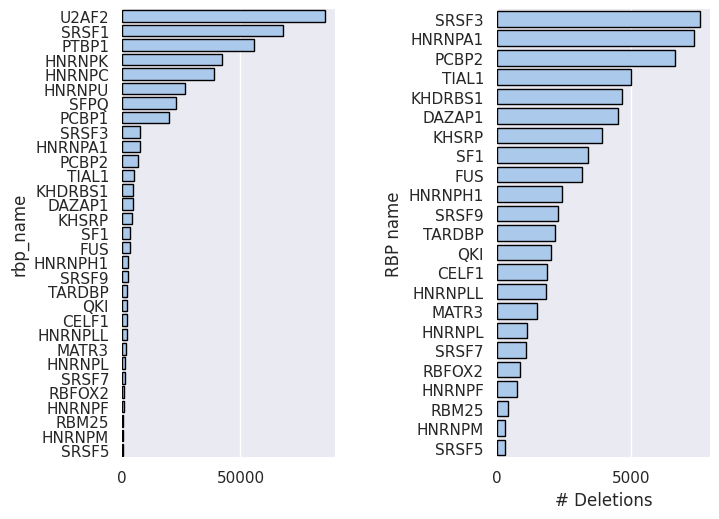

In [15]:
plotMotifOccurrences(DATA)

/tmp/ipykernel_3817052/373192956.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/seaborn/distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


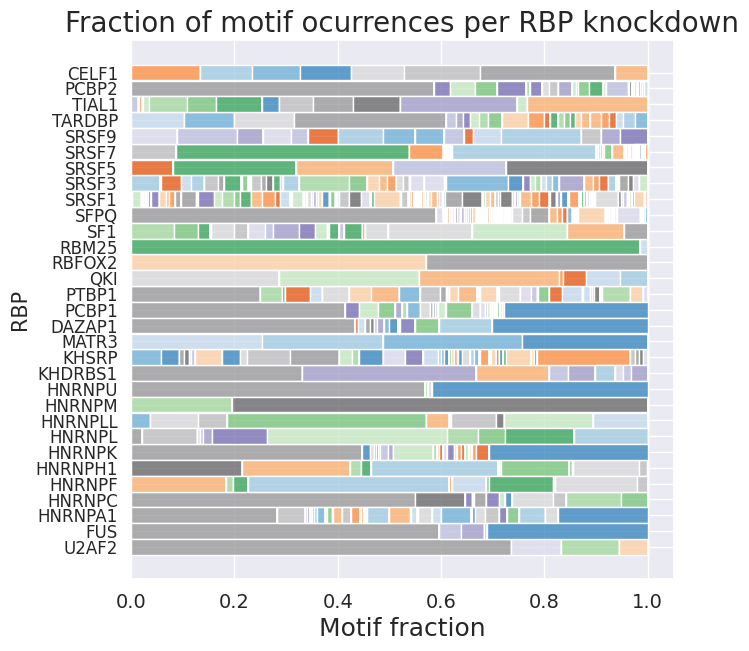

In [16]:
df_pct = plotMotifFraction(DATA)

/tmp/ipykernel_3817052/3704690320.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


0.00165325426664098
[ True  True False False  True False False  True False False False  True
  True False False False False False  True  True False  True  True  True
 False False False False  True False  True]


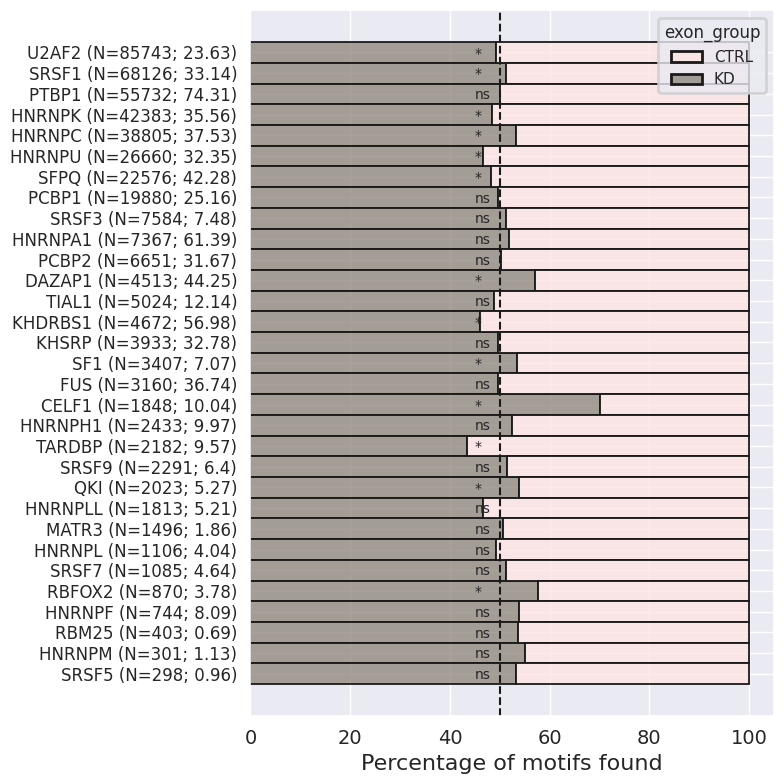

In [17]:
_counts_per_rbp = counts_per_rbp.merge(PAIRED_DATASETS.groupby('rbp_name').size().reset_index().rename(columns={0:'dataset_size'}))
plotMotifOccurrencesPerGroup(doBinomialTest(_counts_per_rbp), show_motif_per_seq_ratio=True)

#### Check effects on each exon of the triplet

In [18]:
_DATA = DATA[DATA.exon_group == "CTRL"]
any_effect_ctrl = _DATA.query('abs(acceptor_upstream_effect) >= 0.05 or abs(donor_upstream_effect) >= 0.05 or \
                              abs(acceptor_cassette_effect) >= 0.05 or abs(donor_cassette_effect) >= 0.05 or \
                              abs(acceptor_downstream_effect) >= 0.05 or abs(donor_downstream_effect) >= 0.05 or \
                              other_acceptor_effect == other_acceptor_effect or \
                              other_donor_effect == other_donor_effect')
print(f"Number of motifs with any effect in control: {any_effect_ctrl.shape[0]}")

_DATA = DATA[DATA.exon_group == "KD"]
any_effect_kd = _DATA.query('abs(acceptor_upstream_effect) >= 0.05 or abs(donor_upstream_effect) >= 0.05 or \
                              abs(acceptor_cassette_effect) >= 0.05 or abs(donor_cassette_effect) >= 0.05 or \
                              abs(acceptor_downstream_effect) >= 0.05 or abs(donor_downstream_effect) >= 0.05 or \
                              other_acceptor_effect == other_acceptor_effect or \
                              other_donor_effect == other_donor_effect')
print(f"Number of motifs with any effect in knockdown: {any_effect_kd.shape[0]}")

Number of motifs with any effect in control: 15986
Number of motifs with any effect in knockdown: 24634


In [19]:
any_effect = DATA.query('abs(acceptor_upstream_effect) >= 0.05 or abs(donor_upstream_effect) >= 0.05 or \
                              abs(acceptor_cassette_effect) >= 0.05 or abs(donor_cassette_effect) >= 0.05 or \
                              abs(acceptor_downstream_effect) >= 0.05 or abs(donor_downstream_effect) >= 0.05 or \
                              other_acceptor_effect == other_acceptor_effect or \
                              other_donor_effect == other_donor_effect')

upstream_effect = DATA.query('abs(acceptor_upstream_effect) >= 0.05 or abs(donor_upstream_effect) >= 0.05')
ups_effect_pos = DATA.query('acceptor_upstream_effect >= 0.05 or donor_upstream_effect >= 0.05')
ups_effect_neg = DATA.query('acceptor_upstream_effect <= -0.05 or donor_upstream_effect <= -0.05')

cassette_effect = DATA.query('abs(acceptor_cassette_effect) >= 0.05 or abs(donor_cassette_effect) >= 0.05')
cass_effect_pos = DATA.query('acceptor_cassette_effect >= 0.05 or donor_cassette_effect >= 0.05')
cass_effect_neg = DATA.query('acceptor_cassette_effect <= -0.05 or donor_cassette_effect <= -0.05')

downstream_effect = DATA.query('abs(acceptor_downstream_effect) >= 0.05 or abs(donor_downstream_effect) >= 0.05')
down_effect_pos = DATA.query('acceptor_downstream_effect >= 0.05 or donor_downstream_effect >= 0.05')
down_effect_neg = DATA.query('acceptor_downstream_effect <= -0.05 or donor_downstream_effect <= -0.05')

other_effect = DATA[(~DATA.other_acceptor_effect.isna()) |
                         (~DATA.other_donor_effect.isna()) ]

In [20]:
# Any effect
any_pct = any_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
upstream_pct = upstream_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
cassette_pct = cassette_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
downstream_pct = downstream_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
other_pct = other_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100

list_dfs = [any_pct, upstream_pct, cassette_pct, downstream_pct, other_pct]
pct_df = pd.concat(list_dfs, axis=1)
pct_df.columns = ['Any', 'Upstream', 'Cassette', 'Downstream', 'Other']
pct_df = pct_df.fillna(0)

# Pos and Neg effects
upstream_pos_pct = ups_effect_pos.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
upstream_neg_pct = ups_effect_neg.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
cassette_pos_pct = cass_effect_pos.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
cassette_neg_pct = cass_effect_neg.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
downstream_pos_pct = down_effect_pos.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
downstream_neg_pct = down_effect_neg.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100

list_dfs_pos_neg = [upstream_pos_pct, upstream_neg_pct, cassette_pos_pct, cassette_neg_pct, downstream_pos_pct, downstream_neg_pct]
pct_df_pos_neg = pd.concat(list_dfs_pos_neg, axis=1)
pct_df_pos_neg.columns = ['+ Upstream', '- Upstream', '+ Cassette', '- Cassette', '+ Downstream', '- Donwstream']
pct_df_pos_neg = pct_df_pos_neg.fillna(0)

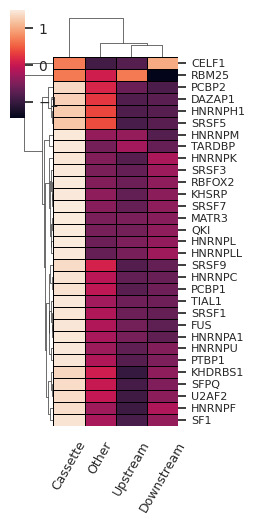

In [21]:
# Overall effects
h = sns.clustermap(pct_df.loc[~(pct_df==0).all(axis=1)].drop('Any', axis=1), 
              z_score=0,linecolor='black',linewidths=0.5, figsize=(3,6), annot=False, yticklabels=True, dendrogram_ratio=[0.2, 0.1])
h.ax_heatmap.set_ylabel("")
xticklabels = h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xmajorticklabels(), rotation=60, fontsize = 9)
yticklabels = h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_ymajorticklabels(), fontsize = 8)
h.fig.savefig('plots/3_mutsplice_effects_clustermap.pdf')

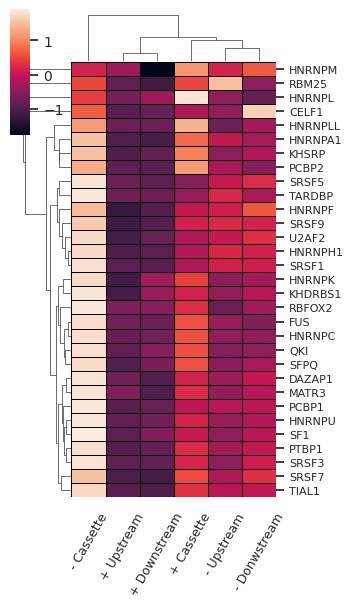

In [22]:
# Specific effects
h = sns.clustermap(pct_df_pos_neg.loc[~(pct_df_pos_neg==0).all(axis=1)], 
              z_score=0,linecolor='black',linewidths=0.5, figsize=(4,7), annot=False, yticklabels=True, dendrogram_ratio=[0.2, 0.1])
h.ax_heatmap.set_ylabel("")
xticklabels = h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xmajorticklabels(), rotation=60, fontsize = 9)
yticklabels = h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_ymajorticklabels(), fontsize = 8)

#### Cassette exon analysis

/tmp/ipykernel_3817052/3704690320.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_3817052/3704690320.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


0.00165325426664098
[False  True  True  True  True False  True  True  True  True  True  True
  True  True False  True False  True  True  True False  True  True  True
  True False False  True False  True  True]


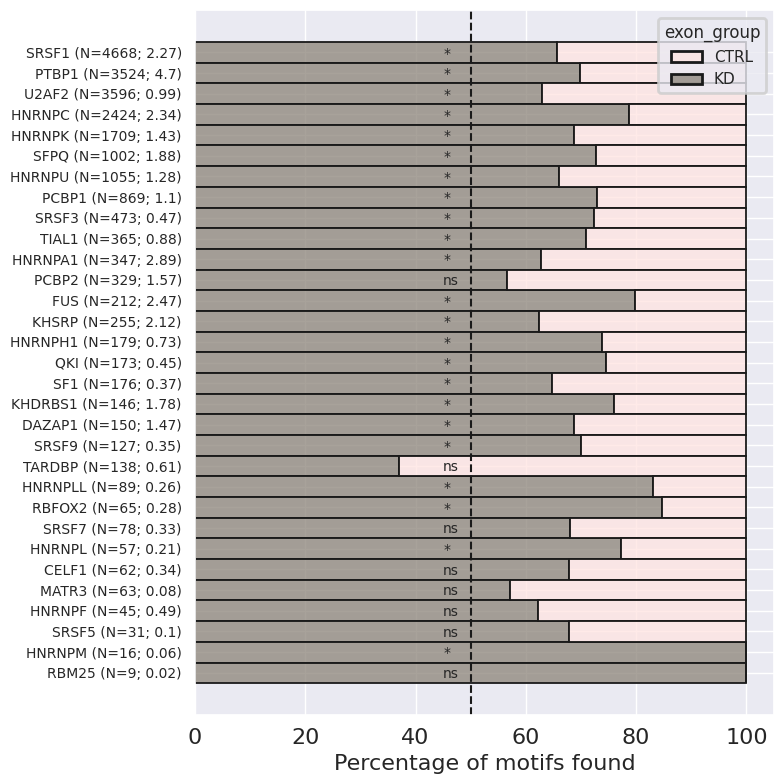

In [23]:
counts_per_rbp_cassette = getCountsPerRBP(cassette_effect).merge(PAIRED_DATASETS.groupby('rbp_name').size().reset_index().rename(columns={0:'dataset_size'}))
plotMotifOccurrencesPerGroup(doBinomialTest(counts_per_rbp_cassette), outbasename='cassette_effect', show_motif_per_seq_ratio=True)

#### Getting the data

In [17]:
def max_abs_effect(row):
    if abs(row[donor_col]) > abs(row[acceptor_col]):
        return row[donor_col]
    else:
        return row[acceptor_col]
    
donor_col = 'donor_cassette_effect'
acceptor_col = 'acceptor_cassette_effect'

In [18]:
# Order RBP data by the number of motif occurrences
_counts = DATA['rbp_name'].value_counts()
DATA['rbp_name'] = DATA['rbp_name'].astype(pd.CategoricalDtype(categories=_counts.index, ordered=True))

# Add a column with the maximum absolute effect
DATA['mutation_effect'] = DATA.apply(max_abs_effect, axis=1)
DATA['cass_diff'] = DATA[[donor_col, acceptor_col]].abs().ge(0.05).any(axis=1)
DATA.is_in_exon = DATA.is_in_exon.replace({True: "Exon", False: "Intron"})
DATA = DATA.rename(columns={"is_in_exon": "Location of motif"})
    
cass = DATA[DATA.exon_group == "KD"].copy()
cass_ctrl = DATA[DATA.exon_group == "CTRL"].copy()

#### Scatterplot to correlation between donor and acceptor

In [26]:
def plotDonorAndAcceptorCorrelation(data: pd.DataFrame, per_rbp: bool = False, group: str = 'KD',  title: str = 'Knockdown', legend: bool = True):
        # Do linear regression to extract the statistics to annotate the plots
        if per_rbp:
                N_df = data.groupby('rbp_name').size().reset_index().rename({0: 'N'}, axis=1)
                N_df['N'] = N_df.N.apply(lambda x: "N={}".format(str(x)))
                p1 = (ggplot(data[data.cass_diff], aes(x=donor_col, y=acceptor_col))
                        + geom_point(aes(color='Location of motif'), size=0.5, alpha = 0.5)
                        + geom_smooth(se=True, method="lm", color="black") 
                        + facet_wrap('rbp_name', ncol=8)
                        + geom_text(data = N_df, mapping=aes(label = 'N', x = 0, y = 0.9), size=8)
                        + labs(x='Donor', y='Acceptor') 
                        + ylim(-1, 1)
                        + xlim(-1, 1)
                        + theme(figure_size=(11, 10), axis_text_y=element_text(size=7), axis_text_x=element_text(size=7, angle=45))
                        + coord_fixed(ratio=1)
                )
                
        else:      
                slope_a, intercept_a, rvalue_a, _, _ = scipy.stats.linregress(data[donor_col], data[acceptor_col])
                with sns.axes_style('white'):
                        plt.figure(figsize=(6, 4))
                        sns.scatterplot(x=donor_col, y=acceptor_col, s=8, hue='Location of motif', data=data, alpha=0.5)
                        sns.regplot(x=donor_col, y=acceptor_col, data=data, scatter=False, color='black')

                        plt.xlim(-1, 1)
                        plt.ylim(-1, 1)
                        plt.xticks(np.arange(-1, 1.1, 0.5))
                        plt.yticks(np.arange(-1, 1.1, 0.5))
                        plt.xlabel('Donor')
                        plt.ylabel('Acceptor')
                        plt.text(0.4, 0.925, "N={}".format(data.shape[0]), transform=plt.gca().transAxes, size=11)
                        plt.text(0.1, 0.875, 'y = {}x + {}, R2 = {}'.format(str(round(slope_a, 3)), str(round(intercept_a, 3)), str(round(rvalue_a ** 2, 3))), transform=plt.gca().transAxes, size=11)
                        plt.gca().set_aspect('equal', adjustable='box')
                        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
                        plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
                        if legend:
                                plt.legend(bbox_to_anchor=(1.05, 0.5), markerscale=3, loc='center left', title='Location of motif')
                        else:
                                plt.legend().remove()
                        plt.xticks(fontsize=12)
                        plt.yticks(fontsize=12)
                        plt.title(title)
                plt.tight_layout()
                plt.savefig(f'plots/3_mutsplice_cassette_donor_accept_correlation_{group}.pdf')

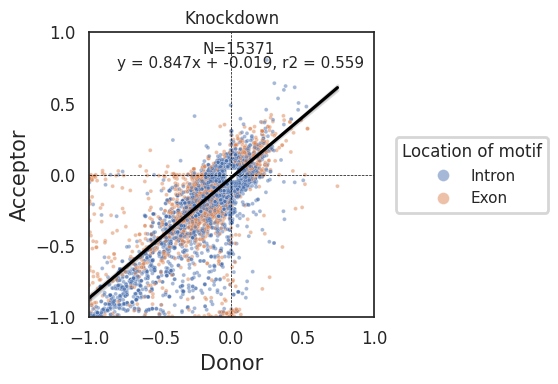

In [27]:
_cass = cass[cass.cass_diff]
plotDonorAndAcceptorCorrelation(_cass)

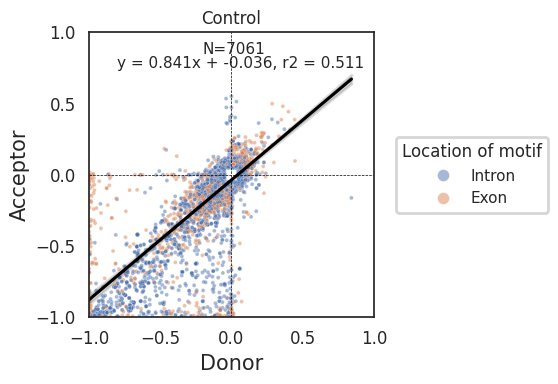

In [28]:
_cass = cass_ctrl[cass_ctrl.cass_diff]
plotDonorAndAcceptorCorrelation(_cass, group="CTRL", title="Control", legend=True)

In [29]:
plotDonorAndAcceptorCorrelation(_cass, per_rbp=True)

/tmp/ipykernel_3817052/1044574148.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


#### Plots on the distribution of motif effects

In [30]:
def plotMotifEffectDistributionMultipleRBPs(cass: pd.DataFrame, group: str, rbps: list = None):
    cass_filt = cass.copy()

    # Change signed values to represent effect of motifs in spliceAI preds
    cass_filt["mutation_effect"] = cass_filt.mutation_effect * (-1)
    cass_filt = cass_filt[
        (cass_filt.mutation_effect <= -0.05) | (cass_filt.mutation_effect >= 0.05)
    ]

    if rbps:
        cass_filt = cass_filt[cass_filt.rbp_name.isin(rbps)]

    cass_filt["Location of motif"] = pd.Categorical(
		cass_filt["Location of motif"], categories=["Exon", "Intron"]
	)
    palette = {"Exon": "teal", "Intron": "orange"}
    f, (ax1, ax2) = plt.subplots(figsize=(5, 5), ncols=2, nrows=1, sharey=True)
    ax1 = sns.violinplot(
        x="mutation_effect",
        y="rbp_name",
        hue="Location of motif",
        palette=palette,
        inner=None,
        split=True,
        data=cass_filt,
        linewidth=0.5,
        ax=ax1,
    )
    ax2 = sns.violinplot(
        x="mutation_effect",
        y="rbp_name",
        hue="Location of motif",
        palette=palette,
        inner=None,
        split=True,
        data=cass_filt,
        linewidth=0.5,
        ax=ax2,
    )

    ax1.set_xlim(-1, -0.05)
    ax2.set_xlim(0.05, 1)
    
    sns.despine(ax=ax1, left=True)
    sns.despine(ax=ax2, left=True)

    plt.subplots_adjust(wspace=0.01)
    ax1.set_xlabel("")
    ax1.set_ylabel("")

    ax2.set_xlabel("")
    ax2.set_ylabel("")

    ax1.legend_.remove()
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, -0.05])
    ax1.tick_params(axis="x", labelsize=10, rotation=45)
    ax1.tick_params(axis="y", labelsize=10)

    ax1.axvline(-0.05, color="k", ls="--")
    ax2.axvline(0.05, color="k", ls="--")
    ax2.set_xticks([0.05, 0.2, 0.4, 0.6, 0.8, 1])
    ax2.tick_params(axis="x", labelsize=10, rotation=45)
    f.supxlabel("Motif effect on SpliceAI prediction", size=12)
    plt.tight_layout()
    plt.title(f"{group} exons")
    plt.savefig(f'plots/3_mutsplice_motif_effect_all_rbps_{group}.pdf')

In [31]:
def plotMotifEffectDistribution(cass: pd.DataFrame, rbp: str):
	sns.set_style("white")
 
	# Plot only relevant changes
	cass_filt = cass[(cass.mutation_effect <= -0.05) | (cass.mutation_effect >= 0.05)]
	cass_filt = cass.copy()

	# Change signed values to represent effect of motifs in spliceAI preds
	cass_filt['mutation_effect'] = cass_filt.mutation_effect * (-1)

	cass_filt=cass_filt[cass_filt.rbp_name == rbp]

	fig, ax = plt.subplots(figsize=(6, 4))
	ax = sns.violinplot(data=cass_filt,
				x='mutation_effect',
				y='rbp_name', 
				hue='Location of motif',
				split=True,
				palette={'Exon': 'teal', 'Intron': 'orange'},
				density_norm='area', 
				common_norm=True,
				orient='h',
				inner=None)

	ax.axvline(-0.05, color='k', ls='--')
	ax.axvline(0.05, color='k', ls='--')
	ax.tick_params(axis='both', which='major', labelsize=10)
	plt.xlabel('Motif effect on SpliceAI prediction', size=12)
	plt.ylabel('')
	plt.tight_layout()

In [32]:
import matplotlib.patches as mpatches
def plotMotifEffectHistogram(cass: pd.DataFrame, rbp: str, group: str):
    cass_filt = cass.copy()
    
    # Change signed values to represent effect of motifs in SpliceAI preds
    cass_filt['mutation_effect'] = cass_filt.mutation_effect * (-1)
    cass_filt=cass_filt[cass_filt.rbp_name == rbp]
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3, 2))

    _values=cass_filt[cass_filt.mutation_effect.abs() > 0.05]
    bins = np.arange(-1,1, 0.05)
    hist_i, _ = np.histogram(_values[_values['Location of motif'] == 'Intron'].mutation_effect, bins=bins)
    hist_e, _ = np.histogram(_values[_values['Location of motif'] == 'Exon'].mutation_effect, bins=bins)
    ymax = max(max(hist_i), max(hist_e))

    for ax, location, color, invert in zip(axes.ravel(), ['Exon', 'Intron'], ['teal', 'orange'], [False,True]):
        values=cass_filt[cass_filt['Location of motif'] == location].mutation_effect
        values=values[values.abs() > 0.05]
        
        kwargs = dict(histtype='stepfilled', alpha=0.8, density=False, edgecolor="black", linewidth=0.5)
        ax.hist(values, bins=bins, color=color, **kwargs)

        ax.text(0.1, 0.8 if location == 'Exon' else 0.8, f'N={len(values)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=8)
        ax.set_xlim(-1, 1)
        ax.set_ylim(0, ymax + 5)
        ax.axvline(-0.05, color='k', linewidth=0.8, ls='--')
        ax.axvline(0.05, color='k', linewidth=0.8, ls='--')
        ax.set_yticks([])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.fill_betweenx(np.arange(0, ymax, 0.1), -0.05, 0.05, color='floralwhite', alpha=1)
        if invert:
            ax.invert_yaxis()
            ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1])
            ax.xaxis.set_ticks_position('bottom') 
            ax.spines['top'].set_color('black') 
            ax.spines['top'].set_linewidth(1)
            ax.spines['bottom'].set_color('black') 
            ax.spines['bottom'].set_linewidth(0.75) 
            ax.tick_params(axis='x', labelsize=7, width=0.5, pad=1, length=2,rotation=60)
        else:
            exon_patch = mpatches.Patch(color='teal', alpha=0.8, label='Exon')
            intron_patch = mpatches.Patch(color='orange', alpha=0.8, label='Intron')
            legend = ax.legend(handles=[exon_patch, intron_patch], edgecolor='k', prop={'size': 7}, frameon=False)

        ax.set_facecolor('white')
        ax.patch.set_linewidth(1)
    
    fig.supylabel(rbp, y=0.525, rotation=0, size=10)
    plt.subplots_adjust(hspace=0)
    fig.patch.set_alpha(0)

    _ = plt.xlabel('Motif effect on SpliceAI prediction', size=10)
    plt.savefig(f'plots/3_mutsplice_motif_effects_dist_{rbp}_{group}.pdf', bbox_inches = "tight")

In [33]:
to_keep = ['target_coordinates', 'exon_group', 'rbp_name', 'dPSI']
cass = cass.merge(PAIRED_DATASETS[to_keep])

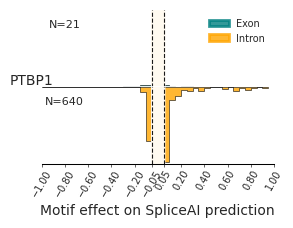

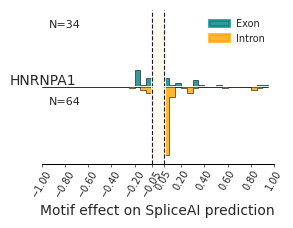

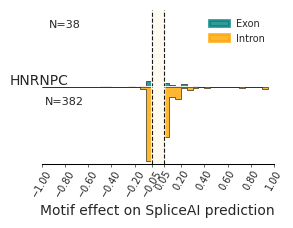

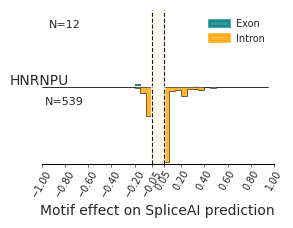

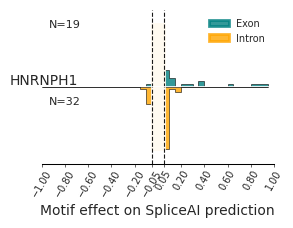

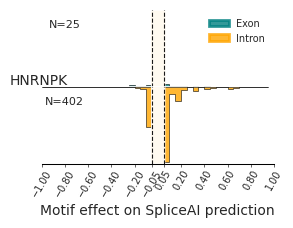

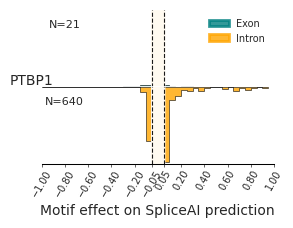

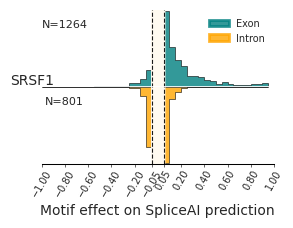

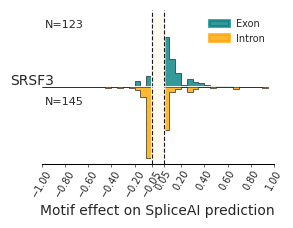

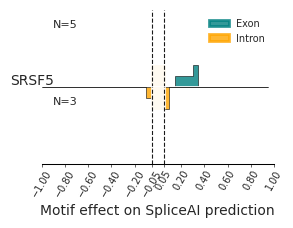

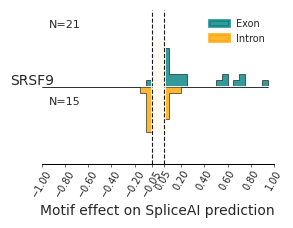

In [34]:
rbps = ['HNRNPA1','HNRNPC','HNRNPU','HNRNPH1','HNRNPK', 'PTBP1','SRSF1','SRSF3','SRSF5','SRSF9']
rbp = 'PTBP1'
plotMotifEffectHistogram(cass[cass.dPSI < 0], rbp, group="KD")
for rbp in rbps:
   plotMotifEffectHistogram(cass[cass.dPSI < 0], rbp, group="KD")

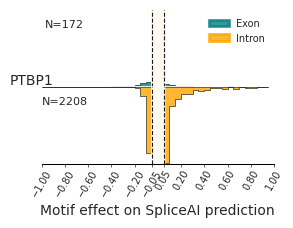

In [35]:
rbp = 'PTBP1'
plotMotifEffectHistogram(cass, rbp, group="KD")
# for rbp in cass_ctrl.rbp_name.unique():
#    plotMotifEffectHistogram(cass_ctrl, rbp, group="CTRL")

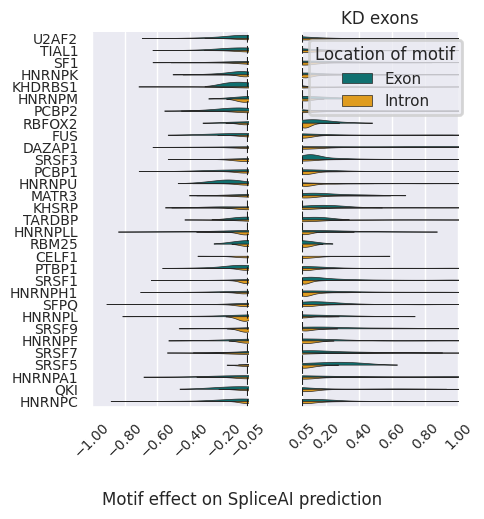

In [36]:
plotMotifEffectDistributionMultipleRBPs(cass, group="KD")

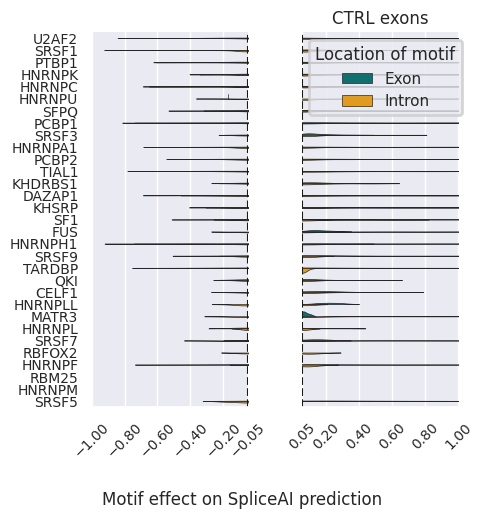

In [37]:
plotMotifEffectDistributionMultipleRBPs(cass_ctrl, group="CTRL")

#### Compare mutation effects between groups

In [38]:
import statsmodels
from scipy.stats import mannwhitneyu
def plotPerturbationEffectBetweenGroups(data: pd.DataFrame):
        def _stat_test(x):
            try:
                return mannwhitneyu(x[x.exon_group == "CTRL"]['mutation_effect'],
                             x[x.exon_group == "KD"]['mutation_effect']).pvalue
            except ValueError:
                return None
        data_positive = data[data.mutation_effect > 0.05]
        data_negative = data[data.mutation_effect < -0.05] 
        
        pvals_positive = data_positive.groupby('rbp_name').apply(_stat_test)
        pvals_negative = data_negative.groupby('rbp_name').apply(_stat_test)

        # _, pval_corrected_positive, _, _ = statsmodels.stats.multitest.multipletests(pvals_positive, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)
        # _, pval_corrected_negative, _, _ = statsmodels.stats.multitest.multipletests(pvals_negative, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)

        is_sign_df_positive = pd.DataFrame({'rbp_name': pvals_positive.index, 'is_sign_pos': pvals_positive})
        is_sign_df_positive['is_sign_pos'] = is_sign_df_positive.is_sign_pos.apply(lambda x: str(round(x, 4)) + "(*)" if x < 0.05 else str(round(x, 2)) + "(ns)")

        is_sign_df_negative = pd.DataFrame({'rbp_name': pvals_negative.index, 'is_sign_neg': pvals_negative})
        is_sign_df_negative['is_sign_neg'] = is_sign_df_negative.is_sign_neg.apply(lambda x: str(round(x, 4)) + "(*)" if x < 0.05 else str(round(x, 2)) + "(ns)")

        data = pd.merge(data, is_sign_df_positive.reset_index(drop=True), on='rbp_name')
        data = pd.merge(data, is_sign_df_negative.reset_index(drop=True), on='rbp_name')
        data['exon_group_effect'] = np.where(data['mutation_effect'] > 0, data['exon_group'] + '_pos', data['exon_group'] + '_neg')
        data['rbp_name'] = pd.Categorical(data['rbp_name'], categories=data['rbp_name'].value_counts().index, ordered=True)
        
        g = sns.FacetGrid(data, col="rbp_name", col_wrap=4, height=2.5, aspect=1)
        palette = sns.color_palette(["lightblue", "#2980b9", "#e74c3c", "#c0392b"])
        g.map(sns.boxplot, "exon_group_effect", "mutation_effect", legend=False, hue="exon_group_effect", data=data, order=["CTRL_neg", "KD_neg", "CTRL_pos", "KD_pos"], palette={'CTRL_neg': 'lightblue',
                                                                                                                                                                                  'KD_neg': '#2980b9',
                                                                                                                                                                                  'CTRL_pos': 'salmon',
                                                                                                                                                                                  'KD_pos': '#c0392b'})
        g.map(sns.stripplot, "exon_group_effect", "mutation_effect", legend=False, hue="exon_group_effect", alpha=0.7, size=3, data=data, order=["CTRL_neg", "KD_neg", "CTRL_pos", "KD_pos"], palette={'CTRL_neg': 'lightblue',
                                                                                                                                                                                  'KD_neg': '#2980b9',
                                                                                                                                                                                  'CTRL_pos': 'salmon',
                                                                                                                                                                                  'KD_pos': '#c0392b'})

        for ax in g.axes.flat:
            title = ax.title.get_text()
            rbp_name = title.split('=')[1].strip()
            num_points = data[data['rbp_name'] == rbp_name].shape[0]
            ax.set_title(f"{rbp_name} (N={num_points})")

            sign_positive = is_sign_df_positive[is_sign_df_positive.rbp_name == rbp_name].iloc[0].is_sign_pos
            sign_negative = is_sign_df_negative[is_sign_df_negative.rbp_name == rbp_name].iloc[0].is_sign_neg
            ax.text(0.3, 0.55, f"p={sign_negative}", transform=ax.transAxes, horizontalalignment='center', fontsize=10)
            ax.text(0.7, 0.9, f"p={sign_positive}", transform=ax.transAxes, horizontalalignment='center', fontsize=10)
            ax.set(xticks=[])
        
        legend_elements = [mpatches.Patch(color='lightblue', label='CTRL_neg'),
                           mpatches.Patch(color='#2980b9', label='KD_neg'),
                           mpatches.Patch(color='salmon', label='CTRL_pos'),
                           mpatches.Patch(color='#c0392b', label='KD_pos')
                           ]
                    
        g.set_xlabels('')
        g.set_ylabels('Perturbation effect')
        g.add_legend(handles=legend_elements, title="", loc=2, bbox_to_anchor=(1.01, 1))#, loc=2, borderaxespad=0.)
        plt.tight_layout()


In [39]:
_DATA = DATA.copy()
_DATA = pd.merge(_DATA, counts_per_rbp[['rbp_name', 'rbp_name_with_N', 'rbp_name_with_split_N']], on='rbp_name')
_DATA = _DATA[~_DATA.rbp_name.isin(counts_per_rbp[counts_per_rbp.total_counts < 50].rbp_name)]

/tmp/ipykernel_3817052/2461179924.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_3817052/2461179924.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


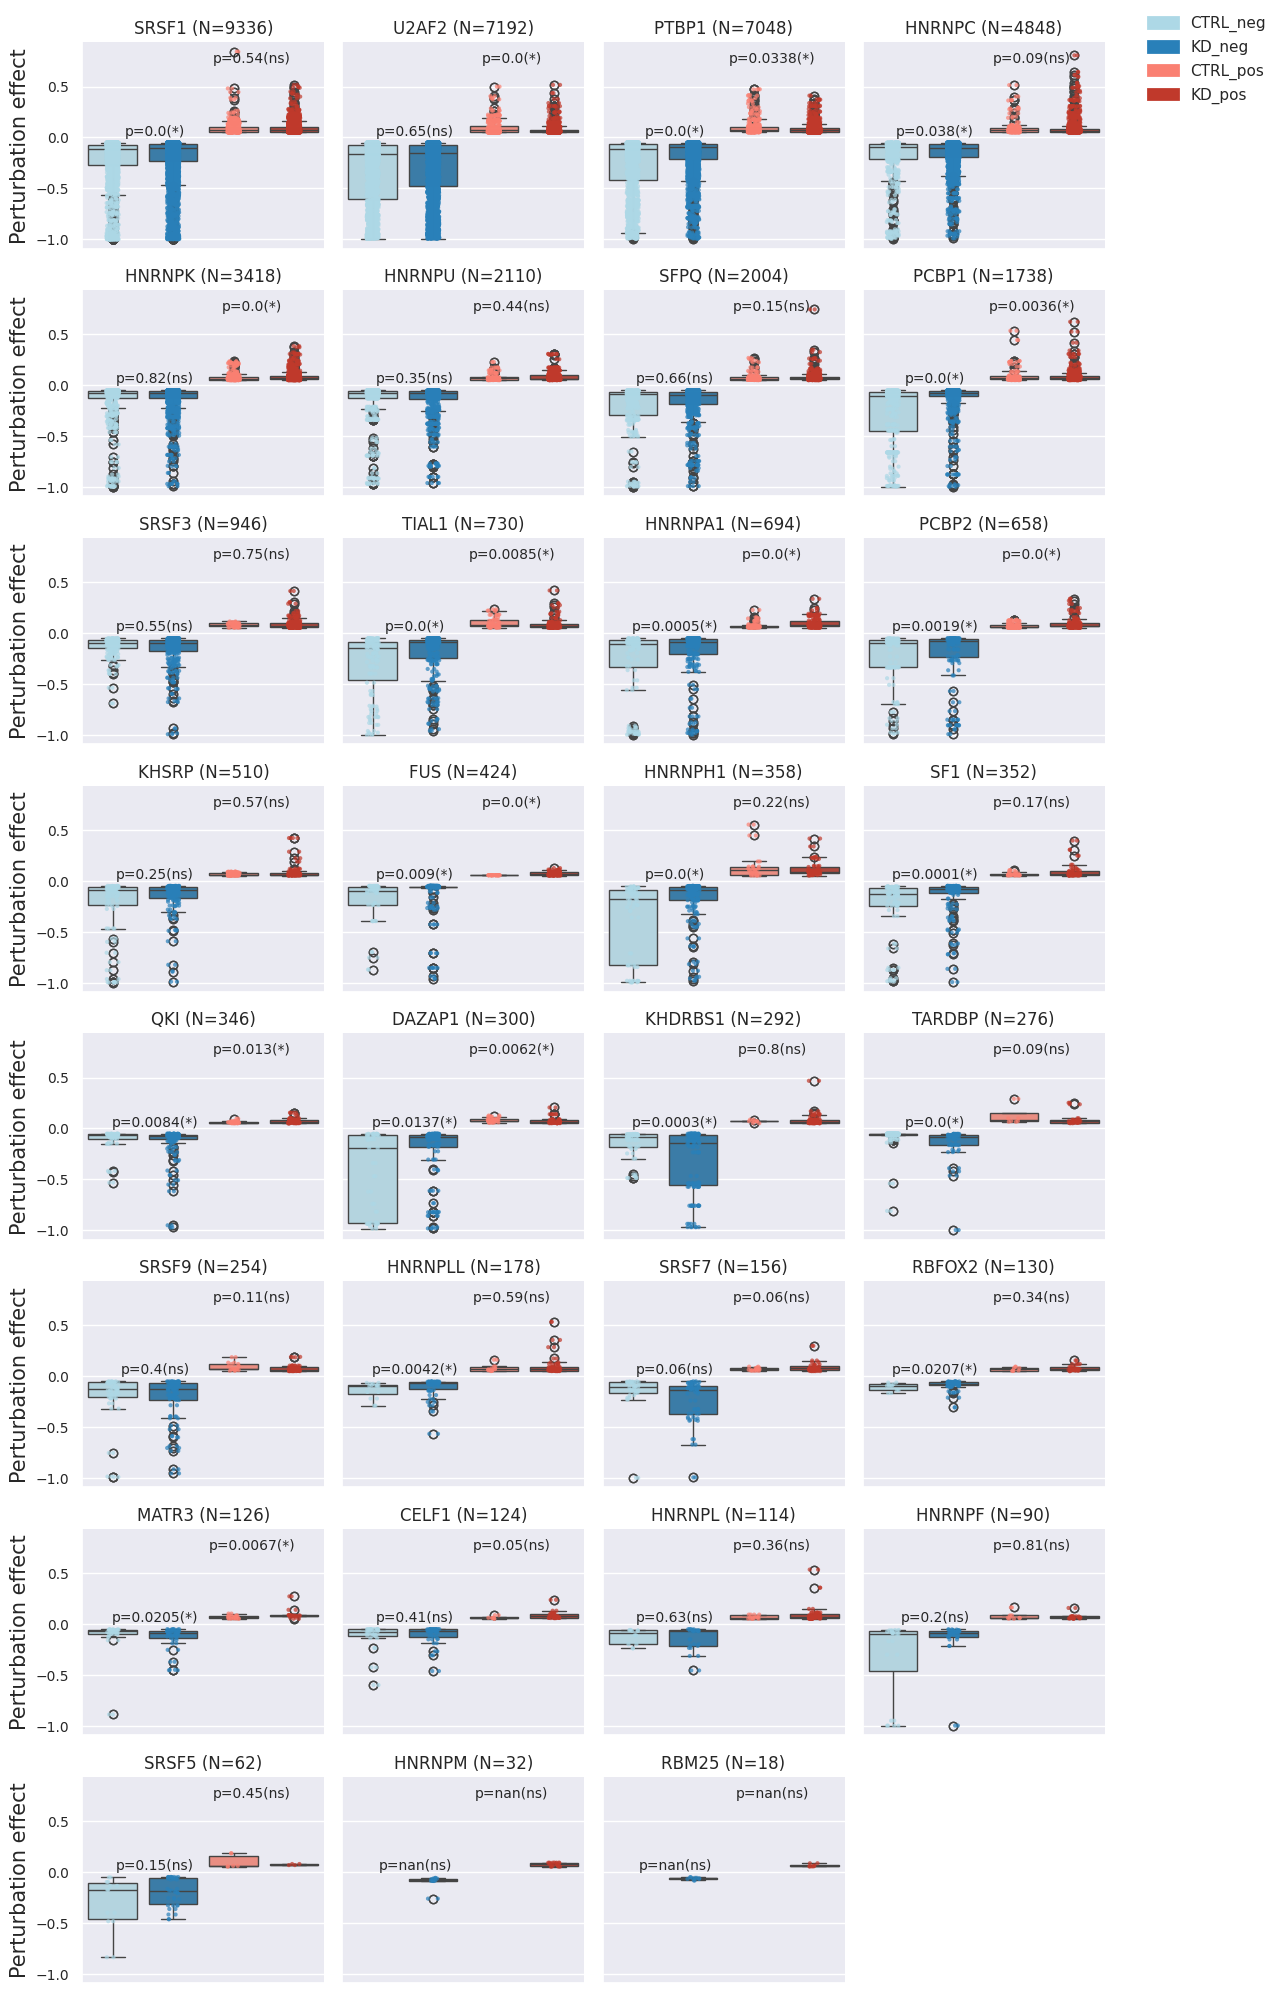

In [40]:
plotPerturbationEffectBetweenGroups(_DATA[_DATA.cass_diff])	

In [41]:
def plotFractionOfMeaningfullEffects(data: pd.DataFrame, rbps: list = None):
    
    data['mutation_effect'] = data['mutation_effect'].abs()
    cass_5pct = data.query('mutation_effect >= 0.05')
    pct_df = cass_5pct.groupby(['rbp_name_with_N', 'exon_group']).size() / data.groupby(['rbp_name_with_N', 'exon_group']).size() * 100
    pct_df = pct_df.reset_index().rename(columns={0: 'frac'})
    pct_df = pd.merge(pct_df, data[['rbp_name_with_N', 'rbp_name', 'rbp_name_with_split_N']].drop_duplicates(), on='rbp_name_with_N')
    pct_df['thresh'] = '>5%'

    if rbps:
        pct_df = pct_df[pct_df.rbp_name.isin(rbps)]

    #fig, ax = plt.subplots(figsize=(6, 4))
    palette={'KD': 'burlywood', 'CTRL': 'gray'}
    ax = sns.catplot(data=pct_df.sort_values('rbp_name'), kind="bar",
                    x="frac", y="rbp_name_with_split_N", hue="exon_group", linewidth=0.5, edgecolor='black', palette=palette, alpha=.8, height=5.5, aspect=1
    )

    ax.set_titles("{col_name}").despine(left=True)
    ax.set_axis_labels("% of perturbations with meaningful effect", "", fontsize=11)
    ax.legend.set_title("")
    plt.tick_params(axis='both', which='major', labelsize=8)
    ax.fig.text(0.265, 0.98, "N_Ctrl; N_KD", fontsize=9)
    #plt.tight_layout()
    plt.savefig('plots/3_mutsplice_motif_percentage_significant.pdf')
    plt.show()
    plt.close()

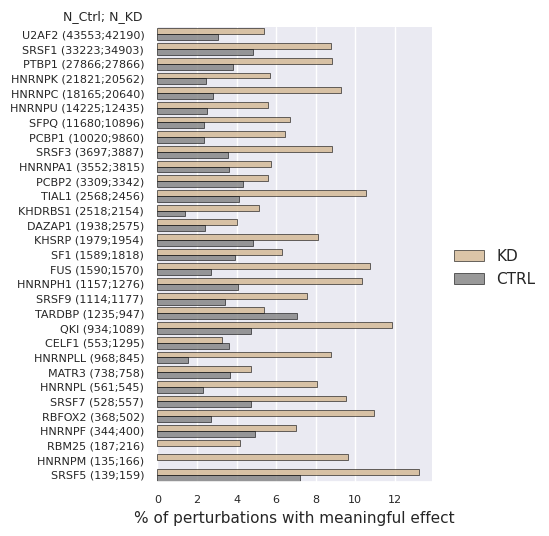

In [42]:
_DATA['rbp_name'] = _DATA['rbp_name'].astype(pd.CategoricalDtype(categories=DATA['rbp_name'].cat.categories, ordered=True))
plotFractionOfMeaningfullEffects(_DATA)	

#### Correlation between RNA-Seq and SpliceAI 

In [13]:
REF_DATA = DATA[DATA.rbp_name.isna()]
to_keep_cols = ['seq_id', 'target_coordinates', 'exon_group', 'start_exon_upstream', 
                'end_exon_upstream', 'start_exon_cassette', 'end_exon_cassette', 
                'start_exon_downstream', 'end_exon_downstream', 'ref_acceptor_cassette',
                'ref_donor_cassette']
REF_DATA = REF_DATA.dropna(axis=1, how='all')[to_keep_cols]
REF_DATA['ref_cassette_score'] = REF_DATA[['ref_donor_cassette', 'ref_acceptor_cassette']].mean(axis=1)

In [14]:
to_keep_cols = ['target_coordinates', 'rbp_name', 'exon_group', 'dPSI']
RNA_SEQ = pd.read_csv('../data/2_paired_datasets/ALL_data.tsv.gz', sep='\t')[to_keep_cols]

In [15]:
def max_abs_index(group):
    abs_values = group['mutation_effect'].abs()
    max_abs_index = abs_values.idxmax()
    return max_abs_index

In [19]:
to_keep_cols = ['seq_id', 'rbp_name', 'target_coordinates', 'exon_group', 'mutation_effect', 'Location of motif']

#Use all sign hits (allowing multiple datapoints for each target exon)
SPLICEAI = DATA[DATA.cass_diff][to_keep_cols]
# Keep max effect only for each target exon
#_DATA = DATA[DATA.cass_diff]
#max_abs_eff_idx = _DATA.groupby(['target_coordinates', 'rbp_name', 'exon_group'], observed=False).apply(max_abs_index).tolist()
#SPLICEAI = _DATA.loc[max_abs_eff_idx]

SPLICEAI_vs_RNASEQ = pd.merge(SPLICEAI, RNA_SEQ, on=['target_coordinates', 'rbp_name', 'exon_group'])
SPLICEAI_vs_RNASEQ = SPLICEAI_vs_RNASEQ[SPLICEAI_vs_RNASEQ.exon_group == 'KD']
SPLICEAI_vs_RNASEQ['rbp_name'] = SPLICEAI_vs_RNASEQ['rbp_name'].astype(pd.CategoricalDtype(categories=DATA['rbp_name'].cat.categories, ordered=True))

In [126]:
from scipy.stats import spearmanr
from plotnine import ggsave


def plotSpliceAI_dPSICorrelation(data: pd.DataFrame, per_rbp: bool = False):
    # Do linear regression to extract the statistics to annotate the plots
    if per_rbp:
        N_df = data.groupby("rbp_name").size().reset_index().rename({0: "N"}, axis=1)
        N_df["N"] = N_df.N.apply(lambda x: "N={}".format(str(x)))
        Corr_df = (
            data.groupby("rbp_name")
            .apply(lambda x: spearmanr(x.mutation_effect, x.dPSI)[0])
            .reset_index()
            .rename({0: "Correlation"}, axis=1)
        )
        Corr_df["Correlation"] = Corr_df.Correlation.apply(
            lambda x: "Spearman={}".format(str(round(x, 2)))
        )
        p1 = (
            ggplot(data, aes(x="dPSI", y="mutation_effect"))
            + geom_point(aes(color="Location of motif"), size=0.1, alpha=0.5)
            # + geom_smooth(se=True, method="lm", color="black")
            + facet_wrap("rbp_name", ncol=8)
            + geom_text(data=N_df, mapping=aes(label="N", x=0, y=0.9), size=8)
            + geom_text(
                data=Corr_df, mapping=aes(label="Correlation", x=0, y=0.7), size=8
            )
            + labs(x="RNA-Seq dPSI", y="SpliceAI effect")
            + ylim(-1, 1)
            + xlim(-1, 1)
            + theme(
                figure_size=(11, 10),
                axis_text_y=element_text(size=7),
                axis_text_x=element_text(size=7, angle=45),
            )
            + coord_fixed(ratio=1)
        )
        return p1

    else:

        correlation, _ = spearmanr(data["mutation_effect"], data["dPSI"])
        p1 = sns.scatterplot(
            data=data,
            x="dPSI",
            y="mutation_effect",
            hue="Location of motif",
            s=10,
            linewidth=0.05,
            edgecolor="black",
            palette='coolwarm',
            alpha=.6,
        )
        p1.set(xlim=(-1, 1), ylim=(-1, 1))
        p1.text(-0.2, 0.9, f"N={data.shape[0]}", fontsize=10)
        p1.text(-0.5, 0.8, f"Spearman's coef = {round(correlation, 2)}", fontsize=9)
        p1.set(xlabel="RNA-Seq dPSI", ylabel="Perturbation effect")
        p1.set_aspect("equal", adjustable="box")
        p1.figure.set_size_inches(5, 5)
        p1.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Location of motif")
        plt.tight_layout()
        plt.savefig('plots/3_mutsplice_spliceAI_dPSI_correlation.png', dpi=1000, bbox_inches='tight', pad_inches=0)
        plt.show()


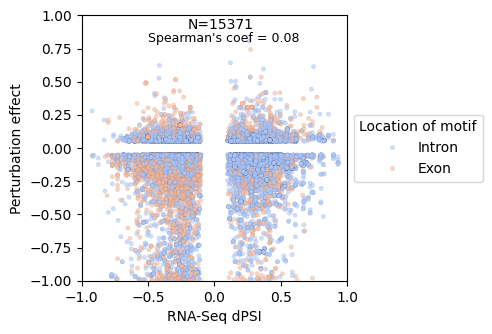

In [127]:
plotSpliceAI_dPSICorrelation(SPLICEAI_vs_RNASEQ, per_rbp=False)

#### Long range feature analysis (distance and region-based)

In [158]:
def plotDistanceHistogram(DIST_DF: pd.DataFrame):
    cass_exon_loc = ['Exon_cassette_acceptor_region', 'Exon_cassette_fully_contained', 'Exon_cassette_donor_region']
    DIST_DF['mutation_effect'] = DIST_DF.mutation_effect.abs()
    DIST_DF['distance_to_cassette'] = DIST_DF.apply(lambda x: min(x.distance_to_cassette_acceptor, x.distance_to_cassette_donor), axis=1)
    DIST_DF['within_exon'] = DIST_DF.location.apply(lambda x: True if x in cass_exon_loc else False)
    DIST_DF['distance'] = DIST_DF.distance_to_cassette.apply(lambda x: '< 500bp' if x < 500 else '> 500bp')

    grid = sns.FacetGrid(DIST_DF, col="distance", row="exon_group", height=2.5, sharex=False, sharey='col', aspect=1)
    grid.map(sns.histplot, 'distance_to_cassette', bins=40, hue='within_exon', alpha=0.6, multiple='stack', data=DIST_DF, palette='Set1')

    grid.set_axis_labels("Distance to splice site", "Count")
    legend_patches = [mpatches.Patch(color=sns.color_palette('Set1')[i], alpha=0.6, label=label) for i, label in enumerate(['Outside exon', 'Within exon'])]

    for ax in grid.axes.flat:
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.tick_params(axis='both', which='major', labelsize=9)
        title = ax.get_title()
        ax.set_title(title.split('|', 1)[1].strip(), fontsize=9)

    for ax in grid.axes.flat:
        ax.legend(handles=legend_patches)
        break
    grid.set_axis_labels("Distance to splice site", "Count", fontsize=10)
    plt.savefig('plots/3_mutsplice_effect_by_distance_all.pdf') 

In [159]:
sns.set(font_scale = 1)
pallette=['#104E8B',  '#97FFFF', '#528B8B', 
          '#CD950C', '#FFF8DC', '#CDC8B1', '#8B8878', '#8B6508',
          '#EEB4B4', '#FA8072', '#8B0000',  '#CD0000', '#EE0000']


def plotBoxplotByLocation(df: pd.DataFrame, per_rbp: bool = False, group: str = 'KD'):
    df = df.copy()
    rename_cols = {"KD": "Knockdown",
                   "CTRL": "Control"}
    df['exon_group'] = df.exon_group.replace(rename_cols)
    if per_rbp:
        df = df[df.exon_group == group]
        N_df = df.groupby('rbp_name').size().reset_index().rename({0: 'N'}, axis=1)
        N_df['N'] = N_df.N.apply(lambda x: "N={}".format(str(x)))
        p1 = (ggplot(df, aes(x='Perturbation location', y='mutation_effect'))
            + geom_boxplot(aes(fill='Perturbation location'), outlier_size=1) 
            + geom_hline(yintercept=0, linetype="dashed", color="black")
            + facet_wrap('rbp_name', ncol=5)
            + geom_text(aes(label='N'), x=7, y=0.8, size=8, color='black', data=N_df)
            + theme(figure_size=(11, 10), axis_ticks_x=element_blank(), axis_text_x=element_blank())
            + scale_fill_manual(values=pallette)
            + ylab('Perturbation effect')
        )
        #p1.save('plots/3_mutsplice_effect_by_location_per_rbp.pdf')
        return p1
    else:

        g = sns.catplot(x="Perturbation location", y="mutation_effect",
                hue_order=hue_order,
                hue="Perturbation location",
                col="exon_group",
                kind='box',
                fliersize= 1.5, 
                height=3.5,
                aspect=1,
                legend=True,
                legend_out=True, 
                palette=pallette, 
                data=df)
        g.fig.subplots_adjust(wspace=0.1)
  
        for ax in g.axes.flat:
            title = ax.title.get_text()
            exon_group = title.split('=')[1].strip()
            num_points = df[df['exon_group'] == exon_group]['Perturbation location'].count()
            ax.set_title(f"{exon_group} (N={num_points})")
            ax.axhline(0, color='black', linestyle='--')

        g.set_xlabels('')
        g.set_ylabels('Perturbation effect')
        plt.ylim(-1, 1)
        plt.xticks([])
        plt.xlabel('')  
        plt.ylabel('Perturbation effect')
        plt.savefig('plots/3_mutsplice_effect_by_location_all.pdf') 


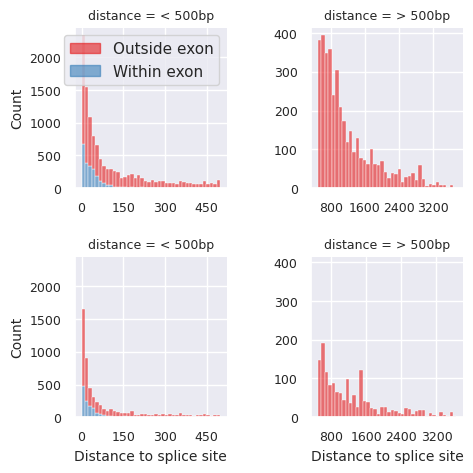

In [160]:
to_keep_cols = ['location', 'target_coordinates', 'exon_group', 'rbp_name', 'mutation_effect', 'distance_to_cassette_acceptor', 'distance_to_cassette_donor']
DIST_DF = DATA[DATA.cass_diff][to_keep_cols]
plotDistanceHistogram(DIST_DF)

In [161]:
hue_order=['Intron_upstream_2', 'Exon_upstream_acceptor_region', 'Exon_upstream_fully_contained', 'Exon_upstream_donor_region', 
           'Intron_upstream', 'Exon_cassette_acceptor_region', 'Exon_cassette_fully_contained', 'Exon_cassette_donor_region', 
           'Intron_downstream', 'Exon_downstream_acceptor_region', 'Exon_downstream_fully_contained', 'Exon_downstream_donor_region', 'Intron_downstream_2']
LOC_DF = DATA[DATA.cass_diff][to_keep_cols]
LOC_DF['location'] = pd.Categorical(LOC_DF['location'], categories=hue_order, ordered=True)
LOC_DF.rename(columns={'location': 'Perturbation location'}, inplace=True)

In [162]:
LOC_DF['Perturbation location'].value_counts()

Perturbation location
Intron_upstream                    9454
Intron_downstream                  8045
Exon_cassette_fully_contained      3013
Intron_upstream_2                   499
Exon_cassette_acceptor_region       316
Exon_downstream_fully_contained     312
Exon_cassette_donor_region          290
Exon_upstream_fully_contained       216
Exon_upstream_donor_region           85
Intron_downstream_2                  66
Exon_downstream_acceptor_region      55
Exon_downstream_donor_region         48
Exon_upstream_acceptor_region        33
Name: count, dtype: int64

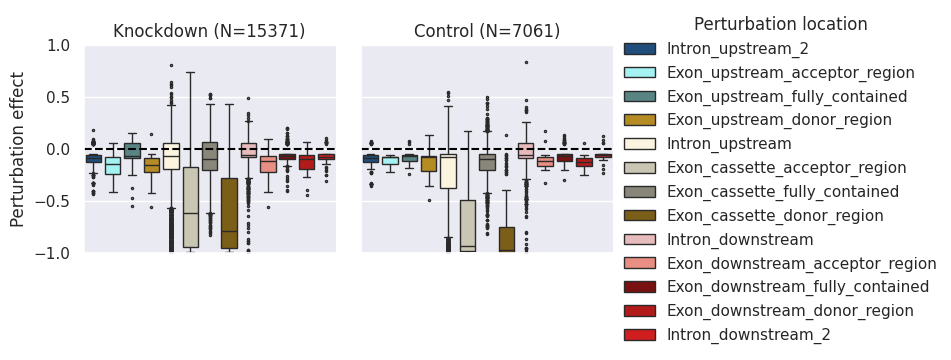

In [163]:
plotBoxplotByLocation(LOC_DF, per_rbp=False)

### RBP maps

In [164]:
def assign_new_location(row):
    """
    Ugly code to restructure location info such that upstream and downstream introns 
    are split according to their distance to the closest exon (cassette or not) 
    """
    if row.location == "Intron_upstream_2":
        return "Upstream_exon_intron_upstream", row.distance_to_acceptor
    elif row.location == "Intron_downstream_2":
        return "Downstream_exon_intron_downstream", row.distance_to_donor
    elif "Exon_cassette" in row.location:
        if all(x >= 50 for x in [row.distance_to_cassette_acceptor, row.distance_to_cassette_donor]):
            return "Cassette_exon_middle", min(row.distance_to_cassette_acceptor, row.distance_to_cassette_donor)
        elif all (x < 50 for x in [row.distance_to_cassette_acceptor, row.distance_to_cassette_donor]):
            if row.distance_to_cassette_donor < row.distance_to_cassette_acceptor:
                return "Cassette_exon_donor_side", row.distance_to_cassette_donor
            else:
                return "Cassette_exon_acceptor_side", row.distance_to_cassette_acceptor
        elif row.distance_to_cassette_acceptor < 50:
            return "Cassette_exon_acceptor_side", row.distance_to_cassette_acceptor
        else:
            return "Cassette_exon_donor_side", row.distance_to_cassette_donor
    elif "Exon_upstream" in row.location:
        if all(x >= 50 for x in [row.distance_to_acceptor, row.distance_to_donor]):
            return "Upstream_exon_middle", min(row.distance_to_acceptor, row.distance_to_donor)
        elif all(x < 50 for x in [row.distance_to_acceptor, row.distance_to_donor]):
            if row.distance_to_donor < row.distance_to_acceptor:
                return "Upstream_exon_donor_side", row.distance_to_donor
            else:
                return "Upstream_exon_acceptor_side", row.distance_to_acceptor
        elif row.distance_to_acceptor < 50:
            return "Upstream_exon_acceptor_side", row.distance_to_acceptor
        else:
            return "Upstream_exon_donor_side", row.distance_to_donor
    elif "Exon_downstream" in row.location:
        if all(x >= 50 for x in [row.distance_to_acceptor, row.distance_to_donor]):
            return "Downstream_exon_middle", min(row.distance_to_acceptor, row.distance_to_donor)
        elif all (x < 50 for x in [row.distance_to_acceptor, row.distance_to_donor]):
            if row.distance_to_donor < row.distance_to_acceptor:
                return "Downstream_exon_donor_side", row.distance_to_donor
            else:
                return "Downstream_exon_acceptor_side", row.distance_to_acceptor
        elif row.distance_to_acceptor < 50:
            return "Downstream_exon_acceptor_side", row.distance_to_acceptor
        else:
            return "Downstream_exon_donor_side", row.distance_to_donor
    elif "Intron_upstream" in row.location:
        if any(x < 500 for x in [row.distance_to_cassette_acceptor, row.distance_to_cassette_donor]):
            return "Cassette_exon_intron_upstream", min(row.distance_to_cassette_acceptor, row.distance_to_cassette_donor)
        else:
            if row.distance_to_donor < 500:
                return "Upstream_exon_intron_downstream", row.distance_to_donor
            else:
                return None, None
    elif "Intron_downstream" in row.location:
        if any(x < 500 for x in [row.distance_to_cassette_acceptor, row.distance_to_cassette_donor]):
            return "Cassette_exon_intron_downstream", min(row.distance_to_cassette_acceptor, row.distance_to_cassette_donor)
        else:
            if row.distance_to_acceptor < 500:
                return "Downstream_exon_intron_upstream", row.distance_to_acceptor
            else:
                return None, None

In [165]:
def _process_data_bin_size50(data: pd.DataFrame) -> pd.DataFrame:
    bin_edges = list(range(-1, data.new_distance.max() + 51, 50))
    data['distance_bin'] = pd.cut(data.new_distance, bins=bin_edges, labels=False, include_lowest=True)
    data['distance_bin'] = data['distance_bin'] * 50
    data['distance_bin'] = data['distance_bin'].astype('str')

    location_cat = ['Upstream_exon_intron_upstream', 'Upstream_exon_acceptor_side', 'Upstream_exon_middle', 'Upstream_exon_donor_side', 'Upstream_exon_intron_downstream', 'Cassette_exon_intron_upstream', 'Cassette_exon_acceptor_side', 'Cassette_exon_middle', 'Cassette_exon_donor_side', 'Cassette_exon_intron_downstream', 'Downstream_exon_intron_upstream', 'Downstream_exon_acceptor_side', 'Downstream_exon_middle', 'Downstream_exon_donor_side', 'Downstream_exon_intron_downstream']

    distance_cat =[str(x) for x in [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]]

    merged_cat = ['Upstream_exon_intron_upstream|50', 'Upstream_exon_intron_upstream|0', 'Upstream_exon_acceptor_side|0', 'Upstream_exon_middle|0', 'Upstream_exon_donor_side|0',
    'Upstream_exon_intron_downstream|0', 'Upstream_exon_intron_downstream|50','Upstream_exon_intron_downstream|100','Upstream_exon_intron_downstream|150','Upstream_exon_intron_downstream|200','Upstream_exon_intron_downstream|250',
    'Upstream_exon_intron_downstream|300','Upstream_exon_intron_downstream|350','Upstream_exon_intron_downstream|400','Upstream_exon_intron_downstream|450',
    'Cassette_exon_intron_upstream|450', 'Cassette_exon_intron_upstream|400','Cassette_exon_intron_upstream|350','Cassette_exon_intron_upstream|300','Cassette_exon_intron_upstream|250','Cassette_exon_intron_upstream|200',
    'Cassette_exon_intron_upstream|150', 'Cassette_exon_intron_upstream|100', 'Cassette_exon_intron_upstream|50', 'Cassette_exon_intron_upstream|0',
    'Cassette_exon_acceptor_side|0', 'Cassette_exon_middle|0', 'Cassette_exon_donor_side|0',
    'Cassette_exon_intron_downstream|0', 'Cassette_exon_intron_downstream|50','Cassette_exon_intron_downstream|100','Cassette_exon_intron_downstream|150','Cassette_exon_intron_downstream|200','Cassette_exon_intron_downstream|250',
    'Cassette_exon_intron_downstream|300', 'Cassette_exon_intron_downstream|350','Cassette_exon_intron_downstream|400','Cassette_exon_intron_downstream|450',
    'Downstream_exon_intron_upstream|450', 'Downstream_exon_intron_upstream|400','Downstream_exon_intron_upstream|350','Downstream_exon_intron_upstream|300','Downstream_exon_intron_upstream|250','Downstream_exon_intron_upstream|200',
    'Downstream_exon_intron_upstream|150','Downstream_exon_intron_upstream|100','Downstream_exon_intron_upstream|50','Downstream_exon_intron_upstream|0',
    'Downstream_exon_acceptor_side|0', 'Downstream_exon_middle|0', 'Downstream_exon_donor_side|0', 'Downstream_exon_intron_downstream|0', 'Downstream_exon_intron_downstream|50']
    data['new_location'] = pd.Categorical(data['new_location'], categories=location_cat, ordered=True)
    data['distance_bin'] = pd.Categorical(data['distance_bin'], categories=distance_cat, ordered=True)
    return data, merged_cat 

In [166]:
def _process_data_bin_size100(data: pd.DataFrame) -> pd.DataFrame:
    bin_edges = list(range(-1, data.new_distance.max() + 101, 100))
    data['distance_bin'] = pd.cut(data.new_distance, bins=bin_edges, labels=False, include_lowest=True)
    data['distance_bin'] = data['distance_bin'] * 100
    data['distance_bin'] = data['distance_bin'].astype('str')

    location_cat = ['Upstream_exon_intron_upstream', 'Upstream_exon_acceptor_side', 'Upstream_exon_middle', 'Upstream_exon_donor_side', 'Upstream_exon_intron_downstream', 'Cassette_exon_intron_upstream', 'Cassette_exon_acceptor_side', 'Cassette_exon_middle', 'Cassette_exon_donor_side', 'Cassette_exon_intron_downstream', 'Downstream_exon_intron_upstream', 'Downstream_exon_acceptor_side', 'Downstream_exon_middle', 'Downstream_exon_donor_side', 'Downstream_exon_intron_downstream']

    distance_cat =[str(x) for x in [0, 100, 200, 300, 400, 500]]

    merged_cat = ['Upstream_exon_intron_upstream|0', 'Upstream_exon_acceptor_side|0', 'Upstream_exon_middle|0', 'Upstream_exon_donor_side|0',
    'Upstream_exon_intron_downstream|0', 'Upstream_exon_intron_downstream|100', 'Upstream_exon_intron_downstream|200', 'Upstream_exon_intron_downstream|300','Upstream_exon_intron_downstream|400',
    'Cassette_exon_intron_upstream|400', 'Cassette_exon_intron_upstream|300', 'Cassette_exon_intron_upstream|200', 'Cassette_exon_intron_upstream|100', 'Cassette_exon_intron_upstream|0',
    'Cassette_exon_acceptor_side|0', 'Cassette_exon_middle|0', 'Cassette_exon_donor_side|0',
    'Cassette_exon_intron_downstream|0','Cassette_exon_intron_downstream|100', 'Cassette_exon_intron_downstream|200', 'Cassette_exon_intron_downstream|300', 'Cassette_exon_intron_downstream|400',
    'Downstream_exon_intron_upstream|400','Downstream_exon_intron_upstream|300','Downstream_exon_intron_upstream|200','Downstream_exon_intron_upstream|100','Downstream_exon_intron_upstream|0',
    'Downstream_exon_acceptor_side|0', 'Downstream_exon_middle|0', 'Downstream_exon_donor_side|0', 'Downstream_exon_intron_downstream|0']
    data['new_location'] = pd.Categorical(data['new_location'], categories=location_cat, ordered=True)
    data['distance_bin'] = pd.Categorical(data['distance_bin'], categories=distance_cat, ordered=True)
    return data, merged_cat

In [243]:
def _draw_rbp_bin_heatmap(data: pd.DataFrame, is_rbp_subset: bool, is_split_ablation_change: bool, title: str, outfile):
    target_locs_downstream = [
        "Cassette_exon_donor_side|0",
        "Downstream_exon_donor_side|0",
        "Upstream_exon_donor_side|0",
        "Cassette_exon_intron_downstream|450",
        "Downstream_exon_intron_downstream|450",
    ]
    target_locs_upstream = [
        "Cassette_exon_acceptor_side|0",
        "Upstream_exon_acceptor_side|0",
        "Downstream_exon_acceptor_side|0",
        "Cassette_exon_intron_upstream|450",
        "Downstream_exon_intron_upstream|450",
    ]

    # data_t = data.transpose()
    # scaler = PowerTransformer()
    # #scaler = MaxAbsScaler()
    # transformed_data = pd.DataFrame(scaler.fit_transform(data_t), index=data_t.index, columns=data_t.columns)
    # transformed_data = transformed_data.transpose()

    if is_rbp_subset and is_split_ablation_change:
        figsize = (5, 5.75)
    elif is_rbp_subset:
        figsize = (5, 5.25)
    elif is_split_ablation_change:
        figsize = (5, 10.25)
    else:
        figsize = (5, 7.25)

    ht = sns.clustermap(
        data,
        cmap="coolwarm",
        row_cluster=True,
        col_cluster=False,
        z_score=0,
        dendrogram_ratio=0.05,
        yticklabels=1,
        xticklabels=1,
        cbar_pos=(1, 0.5, 0.02, 0.2),
        center=0,
        cbar_kws={'label': 'Z-score (Knockdown - Control)'},
        figsize=figsize,
    )

    if title:
        ht.fig.suptitle(title)

    ax = ht.ax_heatmap
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=6)

    for i, label in enumerate(ht.ax_heatmap.get_xticklabels()):
        if label.get_text() in target_locs_downstream:
            ax.axvline(i + 1, color="black", linewidth=1, linestyle="--")
        elif label.get_text() in target_locs_upstream:
            ax.axvline(i, color="black", linewidth=1, linestyle="--")

    ax.set_xlabel("")
    ax.set_ylabel("")
  
    ht.ax_heatmap.yaxis.set_tick_params(labelsize=8)

    if outfile:
        plt.savefig(outfile, bbox_inches='tight')
    plt.show()

In [244]:
def do_per_bin_analysis(
    data: pd.DataFrame,
    bin_size: int,
    split_ablation_change: bool = False,
    subset_rbps: list = None,
    title: str = None,
    outfile: str = None,
):

    # Restructure location info and exclude perturbations at more than >500bp from nearest exon
    data[["new_location", "new_distance"]] = data.apply(
        assign_new_location, axis=1, result_type="expand"
    )
    data["new_distance"] = data["new_distance"].astype("Int64", errors="ignore")
    data = data.dropna(subset=["new_location", "new_distance"])
    data.loc[data["new_location"].str.endswith("_middle"), "new_distance"] = 0
    data.reset_index(inplace=True)

    # Assign distance bin to each location
    if bin_size == 50:
        to_heatmap, merged_cat = _process_data_bin_size50(data)

    elif bin_size == 100:
        to_heatmap, merged_cat = _process_data_bin_size100(data)

    else:
        raise ValueError("Bin size can be either 50 or 100")

    # Create ordered categories for location and distance
    to_heatmap["location"] = (
        to_heatmap.new_location.astype(str) + "|" + to_heatmap.distance_bin.astype(str)
    )
    to_heatmap = to_heatmap[to_heatmap.location.isin(merged_cat)]
    to_heatmap["location"] = pd.Categorical(
        to_heatmap.location, categories=merged_cat, ordered=True
    )

    # Measure differences between knockdown and control sequences, per rbp and location
    if split_ablation_change:
        assert "rbp_name_with_change" in to_heatmap.columns
        t_col = "rbp_name_with_change"
    else:
        t_col = "rbp_name"

    count_diff = to_heatmap.groupby([t_col, "location", "exon_group"]).size().unstack()
    count_diff = count_diff.reset_index()

    # Add pseudo counts to avoid division by zero
    # count_diff['KD'] = count_diff['KD'] + 1
    # count_diff['CTRL'] = count_diff['CTRL'] + 1

    count_diff["difference"] = count_diff["KD"] - count_diff["CTRL"]
    # count_diff['normalized_ratio'] = np.log(count_diff['KD'] / count_diff['CTRL'])
    pivot_df = count_diff.pivot(index=t_col, columns="location", values="difference")

    # Plot the data
    if subset_rbps:
        if split_ablation_change:
            l1 = [x + "(+)" for x in subset_rbps]
            l2 = [x + "(-)" for x in subset_rbps]
            subset_rbps = l1 + l2
        pivot_df = pivot_df.loc[subset_rbps, :]
        
    _draw_rbp_bin_heatmap(
        pivot_df,
        is_rbp_subset=bool(subset_rbps),
        is_split_ablation_change=split_ablation_change,
        title=title,
        outfile=outfile,
    )

In [245]:
cols_to_keep = [
    "id",
    "seq_id",
    "Location of motif",
    "location",
    "distance_to_donor",
    "distance_to_acceptor",
    "distance_to_cassette_donor",
    "distance_to_cassette_acceptor",
    "acceptor_cassette_effect",
    "donor_cassette_effect",
    "target_coordinates",
    "rbp_name",
    "exon_group",
    "cass_diff",
    "mutation_effect",
]

PAIRED_DATASETS_POS_dPSI["more_inclusion"] = True
PAIRED_DATASETS_NEG_dPSI["more_inclusion"] = False
add_dpsi_info = pd.concat([PAIRED_DATASETS_POS_dPSI, PAIRED_DATASETS_NEG_dPSI])
DATA_with_dPSI = DATA.merge(
    add_dpsi_info[["target_coordinates", "rbp_name", "exon_group", "more_inclusion"]],
    on=["target_coordinates", "rbp_name", "exon_group"],
    how="left",
)
to_heatmap = DATA_with_dPSI[DATA_with_dPSI.cass_diff][cols_to_keep].copy()

#### More included exons (dPSI > 0.1)

In [246]:
_to_heatmap = to_heatmap[DATA_with_dPSI.more_inclusion == True].copy()
_to_heatmap['rbp_name_with_change'] = _to_heatmap.apply(lambda x: x.rbp_name + '(+)' if x.mutation_effect > 0.05 else x.rbp_name + '(-)', axis=1)

/tmp/ipykernel_3817052/949705346.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


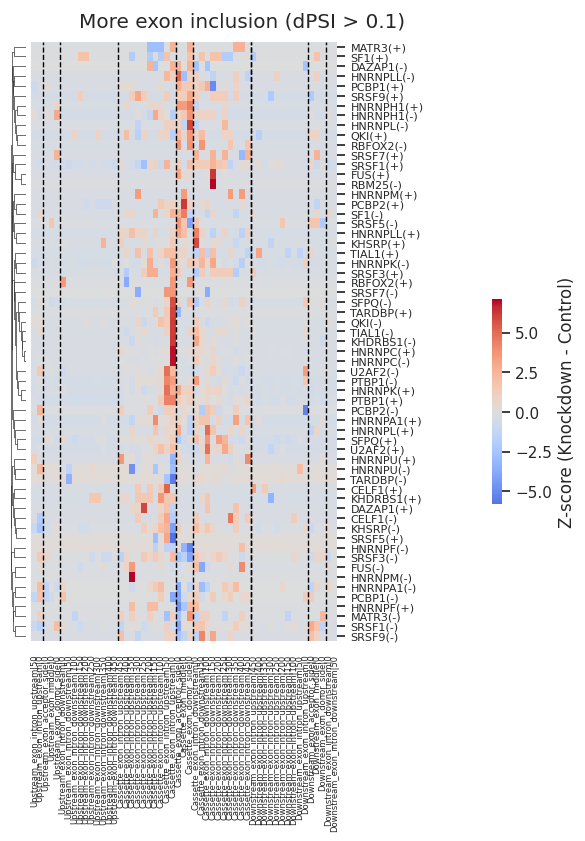

In [247]:
do_per_bin_analysis(
    _to_heatmap,
    bin_size=50,
    split_ablation_change=True,
    title="More exon inclusion (dPSI > 0.1)",
    outfile="plots/3_mutsplice_enrichment_kd_vs_ctrl_pos_dPSI.pdf",
)

#### More excluded exons (dPSI < -0.1)

In [248]:
_to_heatmap = to_heatmap[DATA_with_dPSI.more_inclusion == False].copy()
_to_heatmap['rbp_name_with_change'] = _to_heatmap.apply(lambda x: x.rbp_name + '(+)' if x.mutation_effect > 0.05 else x.rbp_name + '(-)', axis=1)

/tmp/ipykernel_3817052/3683278545.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


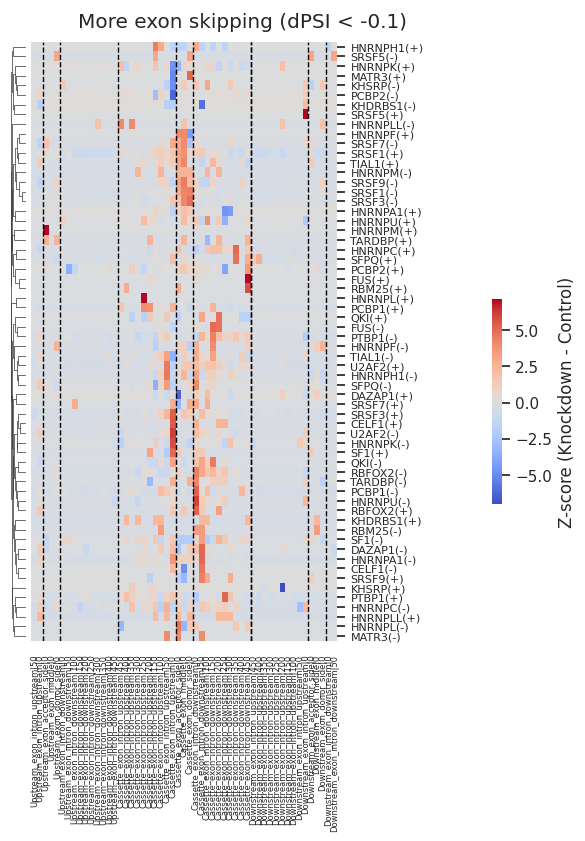

In [249]:
do_per_bin_analysis(
    _to_heatmap,
    bin_size=50,
    split_ablation_change=True,
    title="More exon skipping (dPSI < -0.1)",
    outfile="plots/3_mutsplice_enrichment_kd_vs_ctrl_neg_dPSI.pdf",
)

#### Negative SpliceAI changes

In [250]:
sr_and_hnrnp = [
    "SRSF1",
    "SRSF3",
    "SRSF9",
    "HNRNPA1",
    "HNRNPC",
    "HNRNPU",
    "HNRNPH1",
    "HNRNPK",
    "PTBP1",
]

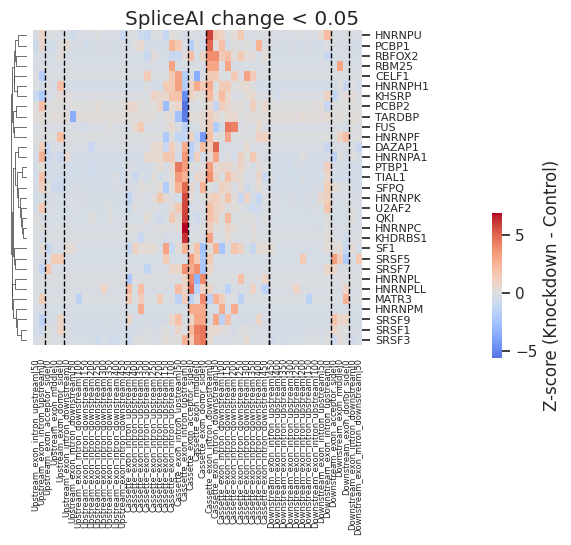

In [251]:
do_per_bin_analysis(
    to_heatmap[to_heatmap.mutation_effect < -0.05],
    bin_size=50,
    subset_rbps=None,
    title="SpliceAI change < 0.05",
    outfile="plots/3_mutsplice_enrichment_kd_vs_ctrl_neg_preds.pdf",
)

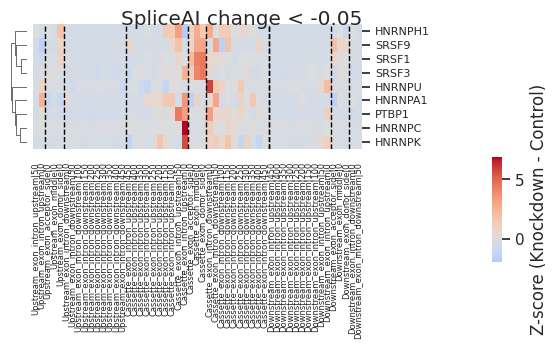

In [252]:
do_per_bin_analysis(
    to_heatmap[to_heatmap.mutation_effect < -0.05],
    bin_size=50,
    subset_rbps=sr_and_hnrnp,
    title="SpliceAI change < -0.05",
    outfile="plots/3_mutsplice_enrichment_kd_vs_ctrl_neg_preds_subset_rbps.pdf",
)

#### Positive SpliceAI changes

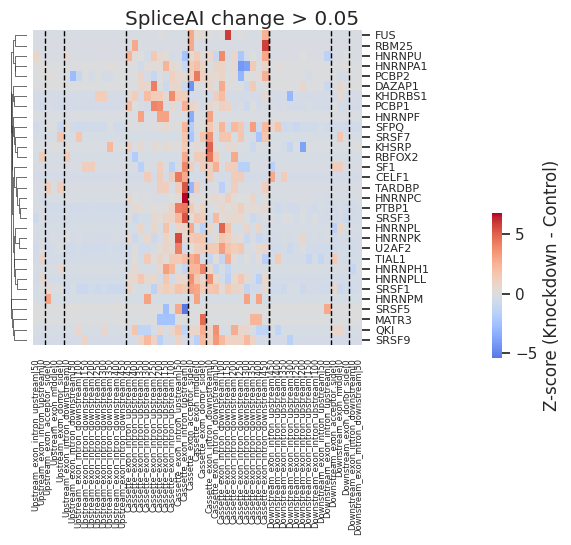

In [253]:
do_per_bin_analysis(
    to_heatmap[to_heatmap.mutation_effect > 0.05],
    bin_size=50,
    subset_rbps=None,
    title="SpliceAI change > 0.05",
    outfile="plots/3_mutsplice_enrichment_kd_vs_ctrl_pos_preds.pdf",
)

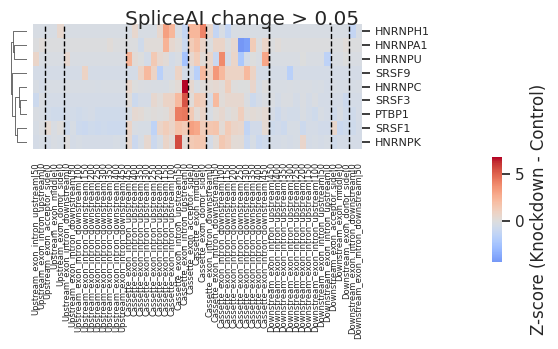

In [254]:
do_per_bin_analysis(
    to_heatmap[to_heatmap.mutation_effect > 0.05],
    bin_size=50,
    subset_rbps=sr_and_hnrnp,
    title="SpliceAI change > 0.05",
    outfile="plots/3_mutsplice_enrichment_kd_vs_ctrl_pos_preds_subset_rbps.pdf",
)

### Meta profiles

In [66]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [67]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.lines as mlines

def plotDistanceMetaProfile(ss: str, data: list, split_pos_neg_effect: bool):
    
    def _common_plot_attributes(ax, i):

        ax.set_xlabel('Distance Bin', fontsize=15)
        ax.tick_params(axis='x', labelsize=12)
        
        if i == 0:
            ax.set_ylabel('SpliceAI variation', fontsize=15)
            ax.tick_params(axis='y', labelsize=12)
   
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_tick_params(labelbottom=True)
        
        plt.xticks(rotation=45)
        ax.tick_params(axis='x', labelrotation=70)
        
        
    sns.set(font_scale=1)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8,4))
    if split_pos_neg_effect:

        neg = data[1::2] 
        pos = data[::2]
        for i, ax in enumerate([ax1, ax2, ax3]):
 
            as_categorical_x_axis = True
            try:
                pos_eff = pos[i].copy()
            except AttributeError:
                pos_eff = None
            
            try:
                neg_eff = neg[i].copy()
                neg_eff['mean'] = neg_eff['mean'] * (-1) 
                neg_eff.ci95_lower = neg_eff.ci95_lower * (-1)
                neg_eff.ci95_upper = neg_eff.ci95_upper * (-1)
                
            except AttributeError:
                neg_eff = None
            
            # Fix absent bins when there's dat afor both pos and neg effect variations
            if all(x is not None and not x.empty for x in [pos_eff, neg_eff]):
                neg_bin_missing = set(pos_eff.DistanceBin).difference(neg_eff.DistanceBin)
                pos_bin_missing = set(neg_eff.DistanceBin).difference(pos_eff.DistanceBin)
                
                if any(len(x) for x in [pos_bin_missing, neg_bin_missing]):
                    as_categorical_x_axis = False

            # pos
            if pos_eff is not None:
                if not pos_eff.empty:
                                   
                    pos_eff['Distance'] = pos_eff.DistanceBin.apply(lambda x: int(x.mid))
                    
                    if as_categorical_x_axis:
                        pos_eff['Distance'] = pos_eff.Distance.astype(str)

                    kd = pos_eff[pos_eff.exon_group == "KD"].copy()
                    ctrl = pos_eff[pos_eff.exon_group == "CTRL"].copy()
                    
                    ax.plot(kd.Distance, kd['mean'], color='darkblue')
                    ax.plot(kd.Distance, kd.ci95_lower, color='darkblue', alpha=0.1)
                    ax.plot(kd.Distance, kd.ci95_upper, color='darkblue', alpha=0.1)
                    ax.fill_between(kd.Distance, kd.ci95_lower, kd.ci95_upper, alpha=0.2)
                    
                    ax.plot(ctrl.Distance, ctrl['mean'], color='darkred')
                    ax.plot(ctrl.Distance, ctrl.ci95_lower, color='darkred', alpha=0.1)
                    ax.plot(ctrl.Distance, ctrl.ci95_upper, color='darkred', alpha=0.1)
                    ax.fill_between(ctrl.Distance, ctrl.ci95_lower, ctrl.ci95_upper, alpha=0.2)
            
                  
            # neg
            if neg_eff is not None:
                if not neg_eff.empty:
                    if not neg_eff.empty and neg_eff is not None:
                        neg_eff['Distance'] = neg_eff.DistanceBin.apply(lambda x: int(x.mid))
                        
                        if as_categorical_x_axis:
                            neg_eff['Distance'] = neg_eff.Distance.astype(str)
                        
                        kd = neg_eff[neg_eff.exon_group == "KD"].copy()
                        ctrl = neg_eff[neg_eff.exon_group == "CTRL"].copy()
                        
                        ax.plot(kd.Distance, kd['mean'], color='darkblue')
                        ax.plot(kd.Distance, kd.ci95_lower, color='darkblue', alpha=0.1)
                        ax.plot(kd.Distance, kd.ci95_upper, color='darkblue', alpha=0.1)
                        ax.fill_between(kd.Distance, kd.ci95_lower, kd.ci95_upper, alpha=0.2)
                        
                        ax.plot(ctrl.Distance, ctrl['mean'], color='darkred')
                        ax.plot(ctrl.Distance, ctrl.ci95_lower, color='darkred', alpha=0.1)
                        ax.plot(ctrl.Distance, ctrl.ci95_upper, color='darkred', alpha=0.1)
                        ax.fill_between(ctrl.Distance, ctrl.ci95_lower, ctrl.ci95_upper, alpha=0.2)
                        #ax.spines['bottom'].set_position('zero')
                
            _df = data[i].copy()
            kd = _df[_df.exon_group == "KD"].copy()
            ctrl = _df[_df.exon_group == "CTRL"].copy() 
            try:
                at_kd = AnchoredText("avg N per Bin = {}".format(int(kd['count'].mean())),
                prop=dict(size=10, color='darkblue'), frameon=True, loc='upper left')
                at_kd.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                ax.add_artist(at_kd)
            except ValueError:
                pass
            
            try:
                at_ctrl = AnchoredText("avg N per Bin = {}".format(int(ctrl['count'].mean())),
                            prop=dict(size=10, color='darkred'), frameon=True,
                            loc='upper right')
                at_ctrl.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                ax.add_artist(at_ctrl)      
            except ValueError:
                pass
                     
            _common_plot_attributes(ax, i)
                    
            if (i != 2 and ss == "donor") or (i== 0 and ss == "acceptor"):
                ax.invert_xaxis()

            if i == 2:
                legend_handles = [mlines.Line2D([], [], color='darkblue', label='KD'),
                                  mlines.Line2D([], [], color='darkred', label='CTRL')]  
                ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.2, 1), prop={'size': 15})
                
        plt.gca().set_ylim(bottom=-1)  
     
    else:
  
        for i, ax in enumerate([ax1, ax2, ax3]):
            _df = data[i].copy()
         
            if not _df.empty:
                    
                _df['Distance'] = _df.DistanceBin.apply(lambda x: int(x.mid))

                _df['Distance'] = _df.Distance.astype(str)
                kd = _df[_df.exon_group == "KD"].copy()
                ctrl = _df[_df.exon_group == "CTRL"].copy()
       
                ax.plot(kd.Distance, kd['mean'], color='darkblue')
                ax.plot(kd.Distance, kd.ci95_lower, color='darkblue', alpha=0.1)
                ax.plot(kd.Distance, kd.ci95_upper, color='darkblue', alpha=0.1)
                ax.fill_between(kd.Distance, kd.ci95_lower, kd.ci95_upper, alpha=0.2)
                
                ax.plot(ctrl.Distance, ctrl['mean'], color='darkred')
                ax.plot(ctrl.Distance, ctrl.ci95_lower, color='darkred', alpha=0.1)
                ax.plot(ctrl.Distance, ctrl.ci95_upper, color='darkred', alpha=0.1)
                ax.fill_between(ctrl.Distance, ctrl.ci95_lower, ctrl.ci95_upper, alpha=0.2)
                
                try:
                    at_kd = AnchoredText("avg N per Bin = {}".format(int(kd['count'].mean())),
                                prop=dict(size=10, color='darkblue'), frameon=True,
                                loc='upper left')
                    at_kd.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                    ax.add_artist(at_kd)
                except ValueError:
                    pass
                
                try:
                    at_ctrl = AnchoredText("avg N per Bin = {}".format(int(ctrl['count'].mean())),
                                prop=dict(size=10, color='darkred'), frameon=True,
                                loc='upper right')
                    at_ctrl.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                    ax.add_artist(at_ctrl)
                except ValueError:
                    pass
            
            _common_plot_attributes(ax, i)
        
            if (i != 2 and ss == "donor") or (i== 0 and ss == "acceptor"):
                ax.invert_xaxis()
            
            if i == 2:
                legend_handles = [mlines.Line2D([], [], color='darkblue', label='KD'),
                                  mlines.Line2D([], [], color='darkred', label='CTRL')]  
                ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.2, 1), prop={'size': 15})
               
        plt.gca().set_ylim(bottom=0)  

    fig.set_figwidth(17)
    plt.subplots_adjust(wspace=0.15)
    plt.show()


In [68]:
# Distances info for cassette exons in tidy format
def distanceInfoToTidy(df: pd.DataFrame):
    """
    Given an input df (filtered at any level),
    generates ouput df in tidy format for 
    downstream plotting
    """
    id_cols = ['id', 'seq_id', 'Location of motif', 'location', 'rbp_name', 'exon_group']
    melt1 = df.melt(id_vars=id_cols, 
                           value_vars=['distance_to_cassette_donor', 'distance_to_cassette_acceptor'], var_name = 'SpliceSite', value_name = 'Distance')
    
    melt2 = df.melt(id_vars=id_cols, 
                           value_vars=['donor_cassette_effect', 'acceptor_cassette_effect'], var_name = 'EffectOn', value_name = 'PerturbationEffect')

    melt1 = melt1.set_index(id_cols + [melt1.groupby(id_cols).cumcount()])
    melt2 = melt2.set_index(id_cols + [melt2.groupby(id_cols).cumcount()])
   
    dist_melt = pd.concat([melt1, melt2], axis=1).sort_index(level=6).reset_index(level=6, drop=True).reset_index()
    dist_melt['SpliceSite'] = dist_melt.SpliceSite.str.replace('distance_to_cassette_', '').str.capitalize()
    dist_melt['EffectOn'] = dist_melt.EffectOn.str.replace('_cassette_effect', '').str.capitalize()
    dist_melt['Distance'] = dist_melt.Distance.astype('Int64', errors='ignore')
    return dist_melt


def createDistanceBin(df: pd.DataFrame, n_bins:int):
    """
    From a df in tidy format, creates an
    additional column representing the 
    distance bin a given mutation is located
    """   
    #df['DistanceBin'] = pd.qcut(df['Distance'], np.arange(0, 1.05, 0.05), duplicates='drop') 
    df['DistanceBin'] = pd.qcut(df['Distance'], n_bins, duplicates='drop') 
    if df.DistanceBin.isna().any():
        return None
    elif df.DistanceBin.isna().any():
        print("BAH")
        print(df)
    else:
        return df


def calculateStats(df: pd.DataFrame):
    """
    Calculates overall stats and confidence intervals
    for the dPSI changes caused by a mutation 
    at given distance bin to splice donors and acceptors
    
    :param pd.DataFrame: Df in tidy format
    """
    if df.empty:
        return df

    stats = df.drop(columns=['Distance', 'Location of motif']).groupby(['EffectOn', 'SpliceSite', 'DistanceBin', 'exon_group']).PerturbationEffect.agg(['mean', 'count', 'std']).dropna()
  
    ci95_up = []
    ci95_lo = []

    for i in stats.index:
        
        m, c, s = stats.loc[i]
        ci95_up.append(m + 1.95*s/math.sqrt(c))
        ci95_lo.append(m - 1.95*s/math.sqrt(c))

    stats['ci95_upper'] = ci95_up
    stats['ci95_lower'] = ci95_lo
    stats = stats.reset_index()
    stats.columns = [x for x in stats.columns.to_flat_index()]
    return stats

In [69]:
def run_all(df: pd.DataFrame, split_pos_neg_effect: bool, only_sign_effect: bool, n_bins: int, name: str):

    if only_sign_effect:
        df = df[(df.PerturbationEffect > 0.05) | (df.PerturbationEffect < - 0.05)]

    # EXONS
    df_exons = df[df['Location of motif'] == "Exon"].copy()
    
    df_exons_donor_effects = df_exons[df_exons.SpliceSite == "Donor"].copy()
    df_exons_donor_effects = createDistanceBin(
        df_exons_donor_effects, n_bins=n_bins)
    
    df_exons_acceptor_effects = df_exons[df_exons.SpliceSite == "Acceptor"].copy()
    df_exons_acceptor_effects = createDistanceBin(
        df_exons_acceptor_effects, n_bins=n_bins)

    # INTRONS
    df_introns = df[df['Location of motif'] == "Intron"].copy()

    df_introns_donor_effects = df_introns[df_introns.SpliceSite == "Donor"].copy()
    df_introns_donor_effects_upstream = createDistanceBin(
        df_introns_donor_effects[df_introns_donor_effects.location == "Intron_upstream"].copy(), n_bins=n_bins)
    df_introns_donor_effects_downstream = createDistanceBin(
        df_introns_donor_effects[df_introns_donor_effects.location == "Intron_downstream"].copy(), n_bins=n_bins)

    df_introns_acceptor_effects = df_introns[df_introns.SpliceSite == "Acceptor"].copy()
    df_introns_acceptor_effects_upstream = createDistanceBin(
        df_introns_acceptor_effects[df_introns_acceptor_effects.location == "Intron_upstream"].copy(), n_bins=n_bins)
    df_introns_acceptor_effects_downstream = createDistanceBin(
        df_introns_acceptor_effects[df_introns_acceptor_effects.location == "Intron_downstream"].copy(), n_bins=n_bins)

    ###############
    #### STATS ####
    ###############
    def _init_empty_df():
        return pd.DataFrame(columns=['id', 'seq_id', 'Location of Motif', 'location',
                                      'rbp_name', 'SpliceSite', 'Distance',
                                      'EffectOn', 'PerturbationEffect', 'DistanceBin'])
        
    info = [df_introns_donor_effects_upstream, df_exons_donor_effects, df_introns_donor_effects_downstream,
            df_introns_acceptor_effects_upstream, df_exons_acceptor_effects, df_introns_acceptor_effects_downstream]
  
    donors_out, acceptors_out = [], []

    for idx, v in enumerate(info):
 
        if v is None:
            v = _init_empty_df().copy()    
   
        if split_pos_neg_effect:
                
            pos = v[v.PerturbationEffect >= 0]
            if not pos.empty:

                pos = calculateStats(pos)

            neg = v[v.PerturbationEffect <= 0]
            if not neg.empty:
                neg['PerturbationEffect'] = neg.PerturbationEffect.abs()
                neg = calculateStats(neg)

            donors_out.extend([pos, neg]) if idx < 3 else acceptors_out.extend([pos, neg])
            
        else:
            v['PerturbationEffect'] = v.PerturbationEffect.abs()
            donors_out.append(calculateStats(v)) if idx < 3 else acceptors_out.append(calculateStats(v))

    plotDistanceMetaProfile(ss='donor',
                            data=donors_out,
                            split_pos_neg_effect=split_pos_neg_effect)
    plt.savefig(f'plots/3_mutsplice_{name}_metaprofile_donors.pdf', bbox_inches='tight')
    plt.close()

    plotDistanceMetaProfile(ss='acceptor',
                            data=acceptors_out,
                            split_pos_neg_effect=split_pos_neg_effect)
    plt.savefig(f'plots/3_mutsplice_{name}_metaprofile_acceptors.pdf', bbox_inches='tight')
    plt.close()


In [81]:
_DATA = DATA.copy()

target_locations = [x for x in _DATA.location.unique().tolist() if isinstance(x, str) and ("cassette" in x or x in ['Intron_upstream', 'Intron_downstream'])]

# Remove large exons
_DATA = _DATA[_DATA.end_exon_cassette - DATA.start_exon_cassette < 500]
_DATA = _DATA[_DATA.location.isin(target_locations)]
_DATA = _DATA[~_DATA.location.isna()]
_DATA = _DATA[cols_to_keep]

In [ ]:
df = distanceInfoToTidy(_DATA)
df = df[df.Distance <= 10000] 

/tmp/ipykernel_3472613/914935276.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/tmp/ipykernel_3472613/914935276.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


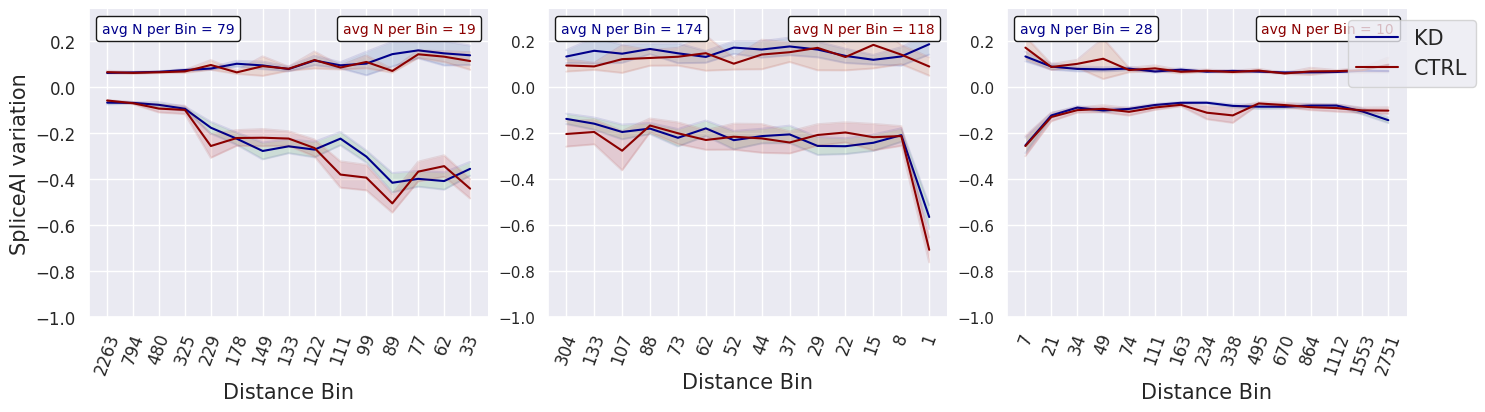

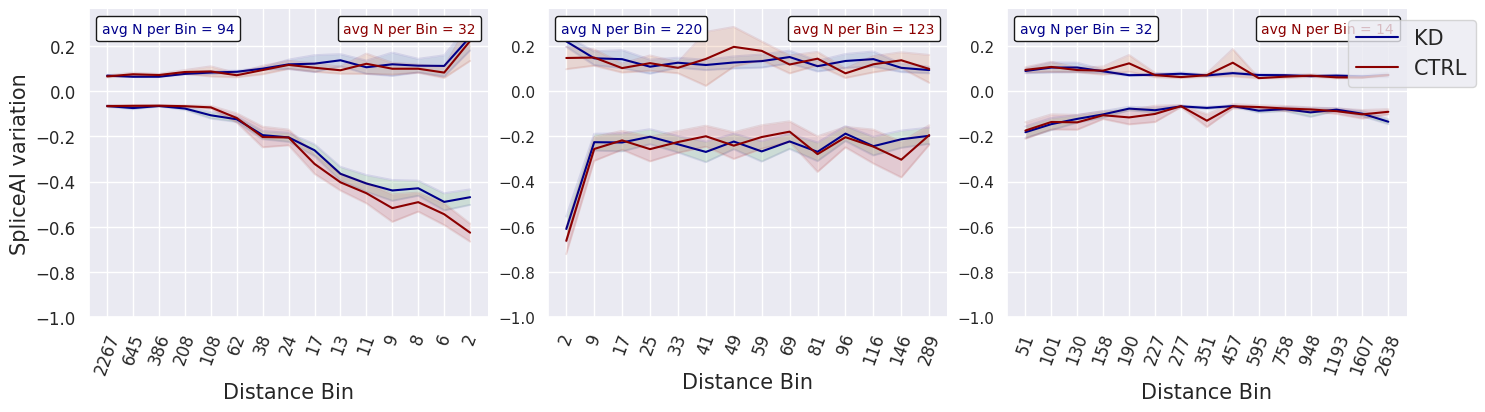

In [ ]:
run_all(df, split_pos_neg_effect=True, only_sign_effect=True, n_bins=15, name='all')

In [ ]:
# Keep only RBPs with more than 500 significant perturbations
df = df[df['PerturbationEffect'].abs() > 0.05]
df = df.groupby('rbp_name').filter(lambda x: len(x) > 500)
#rbps = ['HNRNPA1','HNRNPC','HNRNPF','HNRNPH1','HNRNPK', 'U2AF2', 'PTBP1','SRSF1','SRSF3','SRSF5','SRSF9']
#df = df[df.rbp_name.isin(rbps)]

In [ ]:
for name, group in df.groupby('rbp_name'):
    run_all(group, split_pos_neg_effect=False, only_sign_effect=True, n_bins=10, name=name)